### Cab-Driver Agent

In [160]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import time
import h5py

# for building DQN model
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

#### Defining Time Matrix

In [161]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

In [162]:
Time_matrix[0][3][1][1]

6.0

#### Tracking the state-action pairs for checking convergence


In [163]:
Q_dict = collections.defaultdict(dict)
States_track = collections.defaultdict(dict)

In [164]:
# Defining a function which will add new Q-values to the Q-dictionary. 
def add_to_dict(state):
    if tuple(state) not in Q_dict.keys():
        for action in env.action_space:
        #for action in [i for i in env.action_space if i[0]==state[0]]:    
            Q_dict[tuple(state)][tuple(action)]=0

In [165]:
# Initialise states to be tracked
def initialise_tracking_states():
    #sample_q_values = [((3,0,2),(3,1)),((1,6,3),(2,3)),((2,2,2),(3,2))]
    sample_q_values = [((0,0,0),(0,2))]  
    
    for q_val in sample_q_values:
        state = q_val[0]
        action = q_val[1]
        States_track[state][action] = []

In [166]:
def save_tracking_states():
    for state in States_track.keys():
        #print("state:",state)
        for action in States_track[state].keys():
            #print("action:",action)
            if state in Q_dict and action in Q_dict[state]:
                #print("qdict:",Q_dict[state][action])
                States_track[state][action].append(Q_dict[state][action])

In [167]:
initialise_tracking_states()

In [168]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [169]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.9
        self.learning_rate = 0.01      
        
        self.epsilon = 1
        self.epsilon_max = 1.0
        self.epsilon_decay = 0.0005
        self.epsilon_min = 0.0001
        
        self.batch_size = 512        
        # create replay memory using deque
        self.memory = deque(maxlen=4000)
        
        # Initialize the value of the states tracked
        #self.states_tracked = []
        #self.track_state = np.array(env.state_encod_arch1([0,0,0])).reshape(1, 36)

        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        
        model = Sequential()
        
        # Write your code here: Add layers to your neural nets 
        model.add(Dense(32, input_dim = self.state_size, activation = "relu", kernel_initializer='he_uniform'))
        model.add(Dense(32, activation = "relu", kernel_initializer='he_uniform'))
        model.add(Dense(self.action_size, activation = "relu", kernel_initializer='he_uniform'))
        
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model



    def get_action(self, state, time):
    # Write your code here:
    # get action from model using epsilon-greedy policy
    # Decay in ε after we generate each sample from the environment
    
        #Based on decay example
        self.epsilon = self.epsilon_min + (self.epsilon_max - self.epsilon_min) * np.exp(-self.epsilon_decay*time)
        #print("Episode: ",time)
        #print("Epsilon: ",epsilon)
        
        # generate a random number between 0 an 1 from the probability distribution
        z = np.random.random()
        
        #print("Z: ",z)
        #print("State:", state)
        
        possible_actions_index, actions = env.requests(state)
        
        #print("Possible Action IDx: ",possible_actions_index)
        
        if z <= self.epsilon:
            #action_random = random.choice(actions)
            action_random_idx = random.choice(possible_actions_index)
            #print("Random Action IDX: ",action_random_idx)
            #return action_random
            return action_random_idx
        else:
            # choose the action with the highest q(s, a)
            # get the q(s,a) from NN which accepts the encoded value of state
            state_encode = env.state_encod_arch1(state)
            state_encode = np.array(state_encode).reshape(1, self.state_size)
            
            q_value = self.model.predict(state_encode)
            q_value_possible = [q_value[0][i] for i in possible_actions_index]
            
            #print("Action idx with max q_val: ",possible_actions_index[np.argmax(q_value_possible)])
            
            return possible_actions_index[np.argmax(q_value_possible)]   


    def append_sample(self, state, action, reward, next_state, terminal):
        # Write your code here:
        # save sample <s,a,r,s'> to the replay memory
        self.memory.append((state, action, reward, next_state, terminal))
        
    
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            update_output = np.zeros((self.batch_size, self.state_size))# write here
            update_input = np.zeros((self.batch_size, self.state_size))# write here
            
            actions, rewards, terminals = [], [], []
            
            for i in range(self.batch_size):
                state, action, reward, next_state, terminal = mini_batch[i]
                
                actions.append(action)
                rewards.append(reward)
                terminals.append(terminal)
                
                #1. Update your 'update_output' and 'update_input' batch
                update_input[i] = env.state_encod_arch1(state)
                update_output[i] = env.state_encod_arch1(next_state)
                             
                
                
            # Write your code from here
            # 2. Predict the target from earlier model
            target = self.model.predict(update_input)
            
            #print("target:", target)
            #print("target Q_val: ", target[0][2])
            
            Q_dict[tuple(state)][tuple(env.action_space[action])] = target[0][2]
            
            #print(target[31][15])
            #print(actions[1])
            
            # 3. Get the target for the Q-network
            target_qval = self.model.predict(update_output)
            
            #print("target new Q_val: ", target_qval[0][2])
            
            Q_dict[tuple(next_state)][tuple(env.action_space[action])] = target_qval[0][2]
           
            for i in range(self.batch_size):                
                if terminals[i]:
                    target[i][actions[i]] = rewards[i]
                else: # non-terminal state
                    target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])
                
            # 4. Fit your model and track the loss values
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0) 


    def save(self, name):
        #self.model.save(name)
        self.model.save_weights(name)

In [174]:
Episodes = 15000

threshold = 2000              # no. of episodes after which states_tracked will be saved

### DQN block

In [175]:
start_time = time.time()

# to store rewards in each episode
rewards_per_episode, episodes = [], []

env = CabDriver()

action_size = len(env.action_space)
state_size = len((env.state_encod_arch1(env.state_init))) # m+ t + d

agent = DQNAgent(action_size=action_size, state_size=state_size)

for episode in range(Episodes):

    # Write code here
    # Call the environment
    # Call all the initialised variables of the environment
    
    env = CabDriver() #creating an instance of the class and call environment
    
    action_space, state_space, state = env.reset()
    
    curr_state = state
    
    add_to_dict(curr_state)
    #print("curr:",Q_dict)
    
    total_reward = 0
    total_time_episode = 0
    count = 0
    terminal_state = False

    #Call the DQN agent
    
    while not terminal_state:
        count += 1
        # Write your code here
        
        # 1. Pick epsilon-greedy action from possible actions for the current state
        curr_action_idx = agent.get_action(curr_state, episode)
        curr_action = env.action_space[curr_action_idx]
        
        # 2. Get the target for the Q-network
        #reward, next_state, terminal_state = env.reward_func(curr_state, curr_action, Time_matrix)
        reward, next_state, total_time = env.reward_func(curr_state, curr_action, Time_matrix)
        
        add_to_dict(next_state)
        #print("Next:",Q_dict)
        
        # 3. Append the experience to the memory
        agent.append_sample(curr_state, curr_action_idx, reward, next_state, terminal_state)
        
        # 4. Train the model by calling function agent.train_model
        
        if count%20 == 0:
            #start_time_model = time.time()
            agent.train_model()
            #end_time_model = time.time() - start_time_model
            #print("Model Train Time: ", end_time_model)
        
        # 5. Keep a track of rewards, Q-values, loss
        total_reward = total_reward + reward
        total_time_episode = total_time_episode + total_time
        
        curr_state = next_state
        
        #print("state:",curr_state )
        
        #print("Total Time: ",total_time_episode )
        
        if (total_time_episode >= 24*30):
            terminal_state = True
        #else:
        #    terminal_state = False
        
    
    # store total reward obtained in this episode
    rewards_per_episode.append(total_reward)
    episodes.append(episode)
    
    print("episode:", episode, "  score:", total_reward, "  memory length:",
                      len(agent.memory), "  epsilon:", agent.epsilon)
    
    if ((episode+1) % threshold) == 0:
        save_tracking_states() 
        save_obj(States_track,'States_tracked') 
        agent.save(name="DriverRewardMaximization.h5")

elapsed_time = time.time() - start_time
print('Total time taken ',elapsed_time)

episode: 0   score: 12.0   memory length: 119   epsilon: 1.0
episode: 1   score: -136.0   memory length: 227   epsilon: 0.9995001749666714
episode: 2   score: -61.0   memory length: 333   epsilon: 0.9990005997833917
episode: 3   score: 129.0   memory length: 453   epsilon: 0.9985012743252671
episode: 4   score: -38.0   memory length: 568   epsilon: 0.9980021984674663
episode: 5   score: 15.0   memory length: 685   epsilon: 0.9975033720852203
episode: 6   score: 379.0   memory length: 813   epsilon: 0.9970047950538227
episode: 7   score: 72.0   memory length: 918   epsilon: 0.9965064672486288
episode: 8   score: 152.0   memory length: 1041   epsilon: 0.9960083885450571
episode: 9   score: 253.0   memory length: 1162   epsilon: 0.9955105588185876
episode: 10   score: 139.0   memory length: 1277   epsilon: 0.9950129779447631
episode: 11   score: 25.0   memory length: 1383   epsilon: 0.9945156457991882
episode: 12   score: 8.0   memory length: 1510   epsilon: 0.9940185622575299
episode: 13

episode: 105   score: 337.0   memory length: 4000   epsilon: 0.9488594356236957
episode: 106   score: 318.0   memory length: 4000   epsilon: 0.94838517448105
episode: 107   score: 141.0   memory length: 4000   epsilon: 0.9479111504097028
episode: 108   score: 202.0   memory length: 4000   epsilon: 0.9474373632911481
episode: 109   score: 300.0   memory length: 4000   epsilon: 0.9469638130069393
episode: 110   score: 40.0   memory length: 4000   epsilon: 0.9464904994386885
episode: 111   score: 450.0   memory length: 4000   epsilon: 0.9460174224680676
episode: 112   score: 498.0   memory length: 4000   epsilon: 0.9455445819768072
episode: 113   score: 93.0   memory length: 4000   epsilon: 0.9450719778466973
episode: 114   score: 159.0   memory length: 4000   epsilon: 0.9445996099595867
episode: 115   score: 229.0   memory length: 4000   epsilon: 0.9441274781973835
episode: 116   score: 110.0   memory length: 4000   epsilon: 0.9436555824420548
episode: 117   score: -54.0   memory length:

episode: 208   score: 418.0   memory length: 4000   epsilon: 0.9012351748914625
episode: 209   score: 288.0   memory length: 4000   epsilon: 0.9007847199271425
episode: 210   score: 254.0   memory length: 4000   epsilon: 0.900334490134007
episode: 211   score: 421.0   memory length: 4000   epsilon: 0.8998844853994986
episode: 212   score: 214.0   memory length: 4000   epsilon: 0.8994347056111165
episode: 213   score: 349.0   memory length: 4000   epsilon: 0.8989851506564153
episode: 214   score: 197.0   memory length: 4000   epsilon: 0.8985358204230065
episode: 215   score: 382.0   memory length: 4000   epsilon: 0.8980867147985575
episode: 216   score: 387.0   memory length: 4000   epsilon: 0.8976378336707919
episode: 217   score: 246.0   memory length: 4000   epsilon: 0.8971891769274893
episode: 218   score: 261.0   memory length: 4000   epsilon: 0.8967407444564857
episode: 219   score: 244.0   memory length: 4000   epsilon: 0.8962925361456727
episode: 220   score: -85.0   memory leng

episode: 311   score: 427.0   memory length: 4000   epsilon: 0.8560014782212363
episode: 312   score: 366.0   memory length: 4000   epsilon: 0.8555736344519813
episode: 313   score: 602.0   memory length: 4000   epsilon: 0.8551460045511395
episode: 314   score: 254.0   memory length: 4000   epsilon: 0.8547185884118033
episode: 315   score: 285.0   memory length: 4000   epsilon: 0.8542913859271186
episode: 316   score: 354.0   memory length: 4000   epsilon: 0.8538643969902848
episode: 317   score: 166.0   memory length: 4000   epsilon: 0.8534376214945548
episode: 318   score: 279.0   memory length: 4000   epsilon: 0.8530110593332346
episode: 319   score: 319.0   memory length: 4000   epsilon: 0.8525847103996836
episode: 320   score: 98.0   memory length: 4000   epsilon: 0.8521585745873147
episode: 321   score: 440.0   memory length: 4000   epsilon: 0.8517326517895938
episode: 322   score: 368.0   memory length: 4000   epsilon: 0.8513069419000404
episode: 323   score: 371.0   memory leng

episode: 414   score: 188.0   memory length: 4000   epsilon: 0.8130383480225722
episode: 415   score: 381.0   memory length: 4000   epsilon: 0.8126319804489204
episode: 416   score: 223.0   memory length: 4000   epsilon: 0.8122258160082677
episode: 417   score: 441.0   memory length: 4000   epsilon: 0.8118198545990735
episode: 418   score: 208.0   memory length: 4000   epsilon: 0.811414096119847
episode: 419   score: 658.0   memory length: 4000   epsilon: 0.8110085404691489
episode: 420   score: 137.0   memory length: 4000   epsilon: 0.81060318754559
episode: 421   score: 361.0   memory length: 4000   epsilon: 0.8101980372478323
episode: 422   score: 186.0   memory length: 4000   epsilon: 0.8097930894745882
episode: 423   score: 374.0   memory length: 4000   epsilon: 0.8093883441246206
episode: 424   score: 400.0   memory length: 4000   epsilon: 0.8089838010967432
episode: 425   score: 432.0   memory length: 4000   epsilon: 0.8085794602898203
episode: 426   score: 410.0   memory length

episode: 517   score: 519.0   memory length: 4000   epsilon: 0.7722318101460799
episode: 518   score: 405.0   memory length: 4000   epsilon: 0.7718458407413991
episode: 519   score: 796.0   memory length: 4000   epsilon: 0.7714600642731825
episode: 520   score: 606.0   memory length: 4000   epsilon: 0.7710744806449858
episode: 521   score: 335.0   memory length: 4000   epsilon: 0.7706890897604136
episode: 522   score: 675.0   memory length: 4000   epsilon: 0.7703038915231176
episode: 523   score: 1003.0   memory length: 4000   epsilon: 0.7699188858367986
episode: 524   score: 534.0   memory length: 4000   epsilon: 0.7695340726052051
episode: 525   score: 369.0   memory length: 4000   epsilon: 0.7691494517321337
episode: 526   score: 665.0   memory length: 4000   epsilon: 0.7687650231214291
episode: 527   score: 540.0   memory length: 4000   epsilon: 0.7683807866769845
episode: 528   score: 665.0   memory length: 4000   epsilon: 0.7679967423027404
episode: 529   score: 303.0   memory le

episode: 620   score: 372.0   memory length: 4000   epsilon: 0.7334736115286669
episode: 621   score: 750.0   memory length: 4000   epsilon: 0.7331070163793272
episode: 622   score: 859.0   memory length: 4000   epsilon: 0.7327406044817455
episode: 623   score: 315.0   memory length: 4000   epsilon: 0.7323743757443189
episode: 624   score: 512.0   memory length: 4000   epsilon: 0.7320083300754898
episode: 625   score: 831.0   memory length: 4000   epsilon: 0.7316424673837472
episode: 626   score: 407.0   memory length: 4000   epsilon: 0.7312767875776252
episode: 627   score: 523.0   memory length: 4000   epsilon: 0.7309112905657038
episode: 628   score: 608.0   memory length: 4000   epsilon: 0.730545976256609
episode: 629   score: 522.0   memory length: 4000   epsilon: 0.730180844559012
episode: 630   score: 583.0   memory length: 4000   epsilon: 0.7298158953816299
episode: 631   score: 697.0   memory length: 4000   epsilon: 0.7294511286332255
episode: 632   score: 819.0   memory lengt

episode: 723   score: 420.0   memory length: 4000   epsilon: 0.6966609330158879
episode: 724   score: 424.0   memory length: 4000   epsilon: 0.6963127396049869
episode: 725   score: 533.0   memory length: 4000   epsilon: 0.6959647202472742
episode: 726   score: 911.0   memory length: 4000   epsilon: 0.6956168748557452
episode: 727   score: 699.0   memory length: 4000   epsilon: 0.6952692033434384
episode: 728   score: 596.0   memory length: 4000   epsilon: 0.6949217056234364
episode: 729   score: 822.0   memory length: 4000   epsilon: 0.6945743816088641
episode: 730   score: 665.0   memory length: 4000   epsilon: 0.6942272312128911
episode: 731   score: 837.0   memory length: 4000   epsilon: 0.6938802543487294
episode: 732   score: 671.0   memory length: 4000   epsilon: 0.6935334509296348
episode: 733   score: 907.0   memory length: 4000   epsilon: 0.6931868208689067
episode: 734   score: 1080.0   memory length: 4000   epsilon: 0.6928403640798872
episode: 735   score: 704.0   memory le

episode: 826   score: 542.0   memory length: 4000   epsilon: 0.6616961165995655
episode: 827   score: 533.0   memory length: 4000   epsilon: 0.6613654012269988
episode: 828   score: 882.0   memory length: 4000   epsilon: 0.6610348511707859
episode: 829   score: 466.0   memory length: 4000   epsilon: 0.6607044663482892
episode: 830   score: 279.0   memory length: 4000   epsilon: 0.6603742466769124
episode: 831   score: 1036.0   memory length: 4000   epsilon: 0.6600441920741008
episode: 832   score: 668.0   memory length: 4000   epsilon: 0.6597143024573406
episode: 833   score: 590.0   memory length: 4000   epsilon: 0.6593845777441596
episode: 834   score: 529.0   memory length: 4000   epsilon: 0.6590550178521263
episode: 835   score: 494.0   memory length: 4000   epsilon: 0.6587256226988509
episode: 836   score: 712.0   memory length: 4000   epsilon: 0.6583963922019846
episode: 837   score: 848.0   memory length: 4000   epsilon: 0.6580673262792199
episode: 838   score: 517.0   memory le

episode: 929   score: 918.0   memory length: 4000   epsilon: 0.6284864063470843
episode: 930   score: 739.0   memory length: 4000   epsilon: 0.6281722916791218
episode: 931   score: 1026.0   memory length: 4000   epsilon: 0.6278583340292355
episode: 932   score: 939.0   memory length: 4000   epsilon: 0.6275445333189359
episode: 933   score: 847.0   memory length: 4000   epsilon: 0.627230889469773
episode: 934   score: 504.0   memory length: 4000   epsilon: 0.6269174024033358
episode: 935   score: 759.0   memory length: 4000   epsilon: 0.6266040720412523
episode: 936   score: 922.0   memory length: 4000   epsilon: 0.6262908983051901
episode: 937   score: 850.0   memory length: 4000   epsilon: 0.6259778811168559
episode: 938   score: 1147.0   memory length: 4000   epsilon: 0.6256650203979951
episode: 939   score: 918.0   memory length: 4000   epsilon: 0.6253523160703927
episode: 940   score: 1107.0   memory length: 4000   epsilon: 0.6250397680558725
episode: 941   score: 562.0   memory l

episode: 1032   score: 979.0   memory length: 4000   epsilon: 0.5969437023350905
episode: 1033   score: 854.0   memory length: 4000   epsilon: 0.5966453550769532
episode: 1034   score: 814.0   memory length: 4000   epsilon: 0.5963471569551576
episode: 1035   score: 931.0   memory length: 4000   epsilon: 0.5960491078951543
episode: 1036   score: 796.0   memory length: 4000   epsilon: 0.5957512078224312
episode: 1037   score: 463.0   memory length: 4000   epsilon: 0.5954534566625131
episode: 1038   score: 449.0   memory length: 4000   epsilon: 0.5951558543409623
episode: 1039   score: 810.0   memory length: 4000   epsilon: 0.5948584007833781
episode: 1040   score: 844.0   memory length: 4000   epsilon: 0.5945610959153974
episode: 1041   score: 1160.0   memory length: 4000   epsilon: 0.5942639396626935
episode: 1042   score: 1299.0   memory length: 4000   epsilon: 0.5939669319509777
episode: 1043   score: 954.0   memory length: 4000   epsilon: 0.5936700727059981
episode: 1044   score: 936

episode: 1133   score: 1136.0   memory length: 4000   epsilon: 0.5675514947984243
episode: 1134   score: 811.0   memory length: 4000   epsilon: 0.5672678399706415
episode: 1135   score: 877.0   memory length: 4000   epsilon: 0.5669843269348215
episode: 1136   score: 1029.0   memory length: 4000   epsilon: 0.5667009556200864
episode: 1137   score: 1146.0   memory length: 4000   epsilon: 0.5664177259555931
episode: 1138   score: 678.0   memory length: 4000   epsilon: 0.5661346378705342
episode: 1139   score: 958.0   memory length: 4000   epsilon: 0.5658516912941378
episode: 1140   score: 707.0   memory length: 4000   epsilon: 0.5655688861556671
episode: 1141   score: 1232.0   memory length: 4000   epsilon: 0.5652862223844209
episode: 1142   score: 1025.0   memory length: 4000   epsilon: 0.5650036999097333
episode: 1143   score: 873.0   memory length: 4000   epsilon: 0.5647213186609735
episode: 1144   score: 935.0   memory length: 4000   epsilon: 0.5644390785675464
episode: 1145   score: 

episode: 1234   score: 1184.0   memory length: 4000   epsilon: 0.5396067380105863
episode: 1235   score: 1006.0   memory length: 4000   epsilon: 0.539337052068685
episode: 1236   score: 1045.0   memory length: 4000   epsilon: 0.5390675009360494
episode: 1237   score: 717.0   memory length: 4000   epsilon: 0.5387980845452919
episode: 1238   score: 957.0   memory length: 4000   epsilon: 0.5385288028290584
episode: 1239   score: 596.0   memory length: 4000   epsilon: 0.5382596557200282
episode: 1240   score: 1037.0   memory length: 4000   epsilon: 0.537990643150915
episode: 1241   score: 979.0   memory length: 4000   epsilon: 0.5377217650544652
episode: 1242   score: 917.0   memory length: 4000   epsilon: 0.5374530213634596
episode: 1243   score: 1068.0   memory length: 4000   epsilon: 0.5371844120107121
episode: 1244   score: 792.0   memory length: 4000   epsilon: 0.5369159369290704
episode: 1245   score: 992.0   memory length: 4000   epsilon: 0.5366475960514157
episode: 1246   score: 10

episode: 1335   score: 823.0   memory length: 4000   epsilon: 0.5130381507087568
episode: 1336   score: 1224.0   memory length: 4000   epsilon: 0.5127817457399864
episode: 1337   score: 769.0   memory length: 4000   epsilon: 0.5125254689416551
episode: 1338   score: 1097.0   memory length: 4000   epsilon: 0.5122693202496936
episode: 1339   score: 1363.0   memory length: 4000   epsilon: 0.5120132996000649
episode: 1340   score: 1183.0   memory length: 4000   epsilon: 0.5117574069287638
episode: 1341   score: 1230.0   memory length: 4000   epsilon: 0.5115016421718172
episode: 1342   score: 890.0   memory length: 4000   epsilon: 0.5112460052652835
episode: 1343   score: 1079.0   memory length: 4000   epsilon: 0.5109904961452542
episode: 1344   score: 1216.0   memory length: 4000   epsilon: 0.5107351147478513
episode: 1345   score: 1075.0   memory length: 4000   epsilon: 0.5104798610092298
episode: 1346   score: 1082.0   memory length: 4000   epsilon: 0.5102247348655762
episode: 1347   sco

episode: 1436   score: 1065.0   memory length: 4000   epsilon: 0.4877779619522686
episode: 1437   score: 1372.0   memory length: 4000   epsilon: 0.487534183920879
episode: 1438   score: 790.0   memory length: 4000   epsilon: 0.48729052774803794
episode: 1439   score: 1134.0   memory length: 4000   epsilon: 0.48704699337283136
episode: 1440   score: 1065.0   memory length: 4000   epsilon: 0.4868035807343757
episode: 1441   score: 909.0   memory length: 4000   epsilon: 0.48656028977181764
episode: 1442   score: 1059.0   memory length: 4000   epsilon: 0.48631712042433467
episode: 1443   score: 1017.0   memory length: 4000   epsilon: 0.4860740726311342
episode: 1444   score: 1029.0   memory length: 4000   epsilon: 0.4858311463314546
episode: 1445   score: 831.0   memory length: 4000   epsilon: 0.48558834146456403
episode: 1446   score: 1095.0   memory length: 4000   epsilon: 0.48534565796976137
episode: 1447   score: 1120.0   memory length: 4000   epsilon: 0.48510309578637567
episode: 1448

episode: 1536   score: 1255.0   memory length: 4000   epsilon: 0.46399362708953756
episode: 1537   score: 1424.0   memory length: 4000   epsilon: 0.4637617382530329
episode: 1538   score: 1393.0   memory length: 4000   epsilon: 0.4635299653319653
episode: 1539   score: 1380.0   memory length: 4000   epsilon: 0.46329830826839136
episode: 1540   score: 973.0   memory length: 4000   epsilon: 0.4630667670043969
episode: 1541   score: 1026.0   memory length: 4000   epsilon: 0.4628353414820967
episode: 1542   score: 1157.0   memory length: 4000   epsilon: 0.4626040316436342
episode: 1543   score: 1345.0   memory length: 4000   epsilon: 0.46237283743118207
episode: 1544   score: 1366.0   memory length: 4000   epsilon: 0.46214175878694164
episode: 1545   score: 934.0   memory length: 4000   epsilon: 0.46191079565314336
episode: 1546   score: 918.0   memory length: 4000   epsilon: 0.46167994797204637
episode: 1547   score: 997.0   memory length: 4000   epsilon: 0.46144921568593883
episode: 1548

episode: 1636   score: 1051.0   memory length: 4000   epsilon: 0.44136926792592956
episode: 1637   score: 1460.0   memory length: 4000   epsilon: 0.4411486884414332
episode: 1638   score: 1082.0   memory length: 4000   epsilon: 0.44092821921911113
episode: 1639   score: 1222.0   memory length: 4000   epsilon: 0.4407078602038462
episode: 1640   score: 1201.0   memory length: 4000   epsilon: 0.44048761134054865
episode: 1641   score: 1209.0   memory length: 4000   epsilon: 0.4402674725741562
episode: 1642   score: 1255.0   memory length: 4000   epsilon: 0.4400474438496342
episode: 1643   score: 1356.0   memory length: 4000   epsilon: 0.4398275251119754
episode: 1644   score: 1420.0   memory length: 4000   epsilon: 0.4396077163062002
episode: 1645   score: 1254.0   memory length: 4000   epsilon: 0.4393880173773564
episode: 1646   score: 1110.0   memory length: 4000   epsilon: 0.4391684282705192
episode: 1647   score: 1218.0   memory length: 4000   epsilon: 0.4389489489307914
episode: 1648

episode: 1736   score: 720.0   memory length: 4000   epsilon: 0.4198483117790334
episode: 1737   score: 1521.0   memory length: 4000   epsilon: 0.4196384900829392
episode: 1738   score: 1372.0   memory length: 4000   epsilon: 0.4194287732714697
episode: 1739   score: 1189.0   memory length: 4000   epsilon: 0.41921916129219566
episode: 1740   score: 1075.0   memory length: 4000   epsilon: 0.41900965409271423
episode: 1741   score: 1431.0   memory length: 4000   epsilon: 0.4188002516206484
episode: 1742   score: 1416.0   memory length: 4000   epsilon: 0.4185909538236477
episode: 1743   score: 1024.0   memory length: 4000   epsilon: 0.4183817606493876
episode: 1744   score: 1080.0   memory length: 4000   epsilon: 0.41817267204556996
episode: 1745   score: 1438.0   memory length: 4000   epsilon: 0.4179636879599224
episode: 1746   score: 1461.0   memory length: 4000   epsilon: 0.417754808340199
episode: 1747   score: 1506.0   memory length: 4000   epsilon: 0.4175460331341799
episode: 1748  

episode: 1836   score: 1133.0   memory length: 4000   epsilon: 0.39937694504871624
episode: 1837   score: 828.0   memory length: 4000   epsilon: 0.39917735647749275
episode: 1838   score: 1170.0   memory length: 4000   epsilon: 0.3989778676756105
episode: 1839   score: 1653.0   memory length: 4000   epsilon: 0.39877847859319726
episode: 1840   score: 1374.0   memory length: 4000   epsilon: 0.3985791891804057
episode: 1841   score: 1333.0   memory length: 4000   epsilon: 0.39837999938741353
episode: 1842   score: 1444.0   memory length: 4000   epsilon: 0.3981809091644233
episode: 1843   score: 1286.0   memory length: 4000   epsilon: 0.3979819184616624
episode: 1844   score: 1510.0   memory length: 4000   epsilon: 0.3977830272293832
episode: 1845   score: 1157.0   memory length: 4000   epsilon: 0.3975842354178629
episode: 1846   score: 1098.0   memory length: 4000   epsilon: 0.39738554297740347
episode: 1847   score: 1201.0   memory length: 4000   epsilon: 0.3971869498583319
episode: 184

episode: 1936   score: 1246.0   memory length: 4000   epsilon: 0.37990397865509357
episode: 1937   score: 1629.0   memory length: 4000   epsilon: 0.3797141241333517
episode: 1938   score: 1187.0   memory length: 4000   epsilon: 0.37952436451514293
episode: 1939   score: 1665.0   memory length: 4000   epsilon: 0.37933469975302725
episode: 1940   score: 1165.0   memory length: 4000   epsilon: 0.3791451297995885
episode: 1941   score: 1201.0   memory length: 4000   epsilon: 0.3789556546074341
episode: 1942   score: 1304.0   memory length: 4000   epsilon: 0.3787662741291954
episode: 1943   score: 1570.0   memory length: 4000   epsilon: 0.3785769883175271
episode: 1944   score: 1259.0   memory length: 4000   epsilon: 0.378387797125108
episode: 1945   score: 1427.0   memory length: 4000   epsilon: 0.37819870050464005
episode: 1946   score: 1208.0   memory length: 4000   epsilon: 0.37800969840884924
episode: 1947   score: 1218.0   memory length: 4000   epsilon: 0.377820790790485
episode: 1948

episode: 2036   score: 1339.0   memory length: 4000   epsilon: 0.3613807200391661
episode: 2037   score: 1318.0   memory length: 4000   epsilon: 0.3612001248317108
episode: 2038   score: 1695.0   memory length: 4000   epsilon: 0.3610196198992885
episode: 2039   score: 1192.0   memory length: 4000   epsilon: 0.36083920519677315
episode: 2040   score: 1224.0   memory length: 4000   epsilon: 0.360658880679061
episode: 2041   score: 1436.0   memory length: 4000   epsilon: 0.36047864630107085
episode: 2042   score: 1418.0   memory length: 4000   epsilon: 0.36029850201774405
episode: 2043   score: 1337.0   memory length: 4000   epsilon: 0.3601184477840448
episode: 2044   score: 1556.0   memory length: 4000   epsilon: 0.35993848355495933
episode: 2045   score: 1474.0   memory length: 4000   epsilon: 0.35975860928549663
episode: 2046   score: 937.0   memory length: 4000   epsilon: 0.359578824930688
episode: 2047   score: 1237.0   memory length: 4000   epsilon: 0.3593991304455876
episode: 2048 

episode: 2136   score: 1386.0   memory length: 4000   epsilon: 0.34376085140605955
episode: 2137   score: 1456.0   memory length: 4000   epsilon: 0.34358906393080424
episode: 2138   score: 1334.0   memory length: 4000   epsilon: 0.3434173623278167
episode: 2139   score: 1393.0   memory length: 4000   epsilon: 0.3432457465541715
episode: 2140   score: 1307.0   memory length: 4000   epsilon: 0.34307421656696474
episode: 2141   score: 1376.0   memory length: 4000   epsilon: 0.342902772323314
episode: 2142   score: 1498.0   memory length: 4000   epsilon: 0.34273141378035804
episode: 2143   score: 1414.0   memory length: 4000   epsilon: 0.34256014089525727
episode: 2144   score: 1255.0   memory length: 4000   epsilon: 0.34238895362519356
episode: 2145   score: 1471.0   memory length: 4000   epsilon: 0.34221785192737003
episode: 2146   score: 1313.0   memory length: 4000   epsilon: 0.34204683575901135
episode: 2147   score: 1227.0   memory length: 4000   epsilon: 0.34187590507736326
episode:

episode: 2236   score: 1408.0   memory length: 4000   epsilon: 0.3270003139064114
episode: 2237   score: 1489.0   memory length: 4000   epsilon: 0.32683690460518783
episode: 2238   score: 1637.0   memory length: 4000   epsilon: 0.3266735769881922
episode: 2239   score: 1442.0   memory length: 4000   epsilon: 0.3265103310145925
episode: 2240   score: 1467.0   memory length: 4000   epsilon: 0.32634716664357716
episode: 2241   score: 1298.0   memory length: 4000   epsilon: 0.32618408383435527
episode: 2242   score: 1344.0   memory length: 4000   epsilon: 0.32602108254615597
episode: 2243   score: 1309.0   memory length: 4000   epsilon: 0.32585816273822904
episode: 2244   score: 1367.0   memory length: 4000   epsilon: 0.3256953243698445
episode: 2245   score: 1323.0   memory length: 4000   epsilon: 0.3255325674002927
episode: 2246   score: 1749.0   memory length: 4000   epsilon: 0.3253698917888845
episode: 2247   score: 1479.0   memory length: 4000   epsilon: 0.3252072974949509
episode: 22

episode: 2336   score: 1536.0   memory length: 4000   epsilon: 0.3110571974662985
episode: 2337   score: 1421.0   memory length: 4000   epsilon: 0.3109017577307375
episode: 2338   score: 1289.0   memory length: 4000   epsilon: 0.3107463956956177
episode: 2339   score: 1210.0   memory length: 4000   epsilon: 0.3105911113220983
episode: 2340   score: 1339.0   memory length: 4000   epsilon: 0.3104359045713585
episode: 2341   score: 1075.0   memory length: 4000   epsilon: 0.3102807754045963
episode: 2342   score: 1395.0   memory length: 4000   epsilon: 0.3101257237830296
episode: 2343   score: 1579.0   memory length: 4000   epsilon: 0.30997074966789556
episode: 2344   score: 1624.0   memory length: 4000   epsilon: 0.3098158530204505
episode: 2345   score: 1677.0   memory length: 4000   epsilon: 0.30966103380197024
episode: 2346   score: 1428.0   memory length: 4000   epsilon: 0.3095062919737501
episode: 2347   score: 1165.0   memory length: 4000   epsilon: 0.3093516274971046
episode: 2348 

episode: 2436   score: 1301.0   memory length: 4000   epsilon: 0.295891635990222
episode: 2437   score: 1287.0   memory length: 4000   epsilon: 0.29574377714001987
episode: 2438   score: 1433.0   memory length: 4000   epsilon: 0.2955959922007635
episode: 2439   score: 1434.0   memory length: 4000   epsilon: 0.2954482811355067
episode: 2440   score: 1538.0   memory length: 4000   epsilon: 0.2953006439073218
episode: 2441   score: 1476.0   memory length: 4000   epsilon: 0.2951530804792994
episode: 2442   score: 1453.0   memory length: 4000   epsilon: 0.2950055908145486
episode: 2443   score: 1354.0   memory length: 4000   epsilon: 0.2948581748761971
episode: 2444   score: 1246.0   memory length: 4000   epsilon: 0.29471083262739084
episode: 2445   score: 1574.0   memory length: 4000   epsilon: 0.2945635640312943
episode: 2446   score: 1480.0   memory length: 4000   epsilon: 0.2944163690510902
episode: 2447   score: 1415.0   memory length: 4000   epsilon: 0.29426924764998
episode: 2448   s

episode: 2536   score: 1399.0   memory length: 4000   epsilon: 0.28146570767510354
episode: 2537   score: 1566.0   memory length: 4000   epsilon: 0.2813250599861184
episode: 2538   score: 1623.0   memory length: 4000   epsilon: 0.2811844826033997
episode: 2539   score: 1594.0   memory length: 4000   epsilon: 0.2810439754918031
episode: 2540   score: 1546.0   memory length: 4000   epsilon: 0.28090353861620193
episode: 2541   score: 1375.0   memory length: 4000   epsilon: 0.2807631719414868
episode: 2542   score: 1364.0   memory length: 4000   epsilon: 0.28062287543256614
episode: 2543   score: 1650.0   memory length: 4000   epsilon: 0.28048264905436576
episode: 2544   score: 1642.0   memory length: 4000   epsilon: 0.28034249277182915
episode: 2545   score: 1643.0   memory length: 4000   epsilon: 0.2802024065499172
episode: 2546   score: 1417.0   memory length: 4000   epsilon: 0.2800623903536083
episode: 2547   score: 1476.0   memory length: 4000   epsilon: 0.27992244414789846
episode: 2

episode: 2636   score: 1440.0   memory length: 4000   epsilon: 0.26774334018602486
episode: 2637   score: 1636.0   memory length: 4000   epsilon: 0.2676095519657742
episode: 2638   score: 1449.0   memory length: 4000   epsilon: 0.2674758306229129
episode: 2639   score: 1367.0   memory length: 4000   epsilon: 0.26734217612401057
episode: 2640   score: 1370.0   memory length: 4000   epsilon: 0.26720858843565376
episode: 2641   score: 1294.0   memory length: 4000   epsilon: 0.26707506752444543
episode: 2642   score: 1356.0   memory length: 4000   epsilon: 0.2669416133570054
episode: 2643   score: 1665.0   memory length: 4000   epsilon: 0.26680822589997
episode: 2644   score: 1426.0   memory length: 4000   epsilon: 0.26667490511999253
episode: 2645   score: 1779.0   memory length: 4000   epsilon: 0.2665416509837427
episode: 2646   score: 1619.0   memory length: 4000   epsilon: 0.2664084634579071
episode: 2647   score: 1429.0   memory length: 4000   epsilon: 0.26627534250918866
episode: 264

episode: 2736   score: 1633.0   memory length: 4000   epsilon: 0.2546902204566012
episode: 2737   score: 1561.0   memory length: 4000   epsilon: 0.2545629571648472
episode: 2738   score: 1609.0   memory length: 4000   epsilon: 0.2544357574888338
episode: 2739   score: 1440.0   memory length: 4000   epsilon: 0.2543086213967611
episode: 2740   score: 1599.0   memory length: 4000   epsilon: 0.25418154885684496
episode: 2741   score: 1447.0   memory length: 4000   epsilon: 0.2540545398373175
episode: 2742   score: 1263.0   memory length: 4000   epsilon: 0.25392759430642625
episode: 2743   score: 1148.0   memory length: 4000   epsilon: 0.25380071223243494
episode: 2744   score: 1575.0   memory length: 4000   epsilon: 0.2536738935836229
episode: 2745   score: 1573.0   memory length: 4000   epsilon: 0.2535471383282857
episode: 2746   score: 1730.0   memory length: 4000   epsilon: 0.2534204464347344
episode: 2747   score: 1717.0   memory length: 4000   epsilon: 0.25329381787129596
episode: 274

episode: 2836   score: 1525.0   memory length: 4000   epsilon: 0.24227370888844277
episode: 2837   score: 1530.0   memory length: 4000   epsilon: 0.24215265230066743
episode: 2838   score: 1429.0   memory length: 4000   epsilon: 0.24203165622605652
episode: 2839   score: 1404.0   memory length: 4000   epsilon: 0.24191072063436092
episode: 2840   score: 1491.0   memory length: 4000   epsilon: 0.24178984549534674
episode: 2841   score: 1601.0   memory length: 4000   epsilon: 0.24166903077879515
episode: 2842   score: 1430.0   memory length: 4000   epsilon: 0.24154827645450255
episode: 2843   score: 1748.0   memory length: 4000   epsilon: 0.2414275824922803
episode: 2844   score: 1547.0   memory length: 4000   epsilon: 0.241306948861955
episode: 2845   score: 1451.0   memory length: 4000   epsilon: 0.24118637553336805
episode: 2846   score: 1632.0   memory length: 4000   epsilon: 0.24106586247637632
episode: 2847   score: 1335.0   memory length: 4000   epsilon: 0.24094540966085146
episode

episode: 2935   score: 1628.0   memory length: 4000   epsilon: 0.23057796791416896
episode: 2936   score: 1573.0   memory length: 4000   epsilon: 0.23046275773515684
episode: 2937   score: 1597.0   memory length: 4000   epsilon: 0.23034760514683533
episode: 2938   score: 1534.0   memory length: 4000   epsilon: 0.23023251012041634
episode: 2939   score: 1525.0   memory length: 4000   epsilon: 0.23011747262712606
episode: 2940   score: 1612.0   memory length: 4000   epsilon: 0.23000249263820516
episode: 2941   score: 1132.0   memory length: 4000   epsilon: 0.22988757012490857
episode: 2942   score: 1624.0   memory length: 4000   epsilon: 0.22977270505850575
episode: 2943   score: 1318.0   memory length: 4000   epsilon: 0.2296578974102804
episode: 2944   score: 1461.0   memory length: 4000   epsilon: 0.22954314715153057
episode: 2945   score: 1684.0   memory length: 4000   epsilon: 0.22942845425356875
episode: 2946   score: 1425.0   memory length: 4000   epsilon: 0.22931381868772163
episo

episode: 3035   score: 1577.0   memory length: 4000   epsilon: 0.21933742477908894
episode: 3036   score: 1444.0   memory length: 4000   epsilon: 0.21922783346681063
episode: 3037   score: 1540.0   memory length: 4000   epsilon: 0.21911829693649182
episode: 3038   score: 1744.0   memory length: 4000   epsilon: 0.21900881516074835
episode: 3039   score: 1716.0   memory length: 4000   epsilon: 0.21889938811220985
episode: 3040   score: 1766.0   memory length: 4000   epsilon: 0.2187900157635195
episode: 3041   score: 1621.0   memory length: 4000   epsilon: 0.21868069808733429
episode: 3042   score: 1684.0   memory length: 4000   epsilon: 0.21857143505632465
episode: 3043   score: 1623.0   memory length: 4000   epsilon: 0.21846222664317494
episode: 3044   score: 1358.0   memory length: 4000   epsilon: 0.21835307282058308
episode: 3045   score: 1431.0   memory length: 4000   epsilon: 0.21824397356126052
episode: 3046   score: 1747.0   memory length: 4000   epsilon: 0.21813492883793245
episo

episode: 3135   score: 1746.0   memory length: 4000   epsilon: 0.20864508940163132
episode: 3136   score: 1762.0   memory length: 4000   epsilon: 0.20854084292072256
episode: 3137   score: 1696.0   memory length: 4000   epsilon: 0.2084366485500256
episode: 3138   score: 1425.0   memory length: 4000   epsilon: 0.20833250626349187
episode: 3139   score: 1401.0   memory length: 4000   epsilon: 0.20822841603508574
episode: 3140   score: 1677.0   memory length: 4000   epsilon: 0.20812437783878476
episode: 3141   score: 1510.0   memory length: 4000   epsilon: 0.20802039164857927
episode: 3142   score: 1822.0   memory length: 4000   epsilon: 0.20791645743847284
episode: 3143   score: 1606.0   memory length: 4000   epsilon: 0.20781257518248178
episode: 3144   score: 1244.0   memory length: 4000   epsilon: 0.20770874485463564
episode: 3145   score: 1538.0   memory length: 4000   epsilon: 0.2076049664289768
episode: 3146   score: 1797.0   memory length: 4000   epsilon: 0.20750123987956065
episod

episode: 3234   score: 1722.0   memory length: 4000   epsilon: 0.19857343728756224
episode: 3235   score: 1578.0   memory length: 4000   epsilon: 0.19847422537396378
episode: 3236   score: 1512.0   memory length: 4000   epsilon: 0.19837506305392266
episode: 3237   score: 1814.0   memory length: 4000   epsilon: 0.19827595030264836
episode: 3238   score: 1796.0   memory length: 4000   epsilon: 0.1981768870953627
episode: 3239   score: 1817.0   memory length: 4000   epsilon: 0.19807787340729982
episode: 3240   score: 1619.0   memory length: 4000   epsilon: 0.19797890921370628
episode: 3241   score: 2009.0   memory length: 4000   epsilon: 0.19787999448984114
episode: 3242   score: 1692.0   memory length: 4000   epsilon: 0.19778112921097563
episode: 3243   score: 1687.0   memory length: 4000   epsilon: 0.19768231335239347
episode: 3244   score: 1762.0   memory length: 4000   epsilon: 0.19758354688939064
episode: 3245   score: 1662.0   memory length: 4000   epsilon: 0.19748482979727558
episo

episode: 3334   score: 1714.0   memory length: 4000   epsilon: 0.18889377352972636
episode: 3335   score: 1500.0   memory length: 4000   epsilon: 0.18879940023825048
episode: 3336   score: 1678.0   memory length: 4000   epsilon: 0.18870507412162565
episode: 3337   score: 1671.0   memory length: 4000   epsilon: 0.1886107951562703
episode: 3338   score: 1498.0   memory length: 4000   epsilon: 0.18851656331861474
episode: 3339   score: 2044.0   memory length: 4000   epsilon: 0.18842237858510102
episode: 3340   score: 1778.0   memory length: 4000   epsilon: 0.18832824093218292
episode: 3341   score: 1632.0   memory length: 4000   epsilon: 0.18823415033632598
episode: 3342   score: 1669.0   memory length: 4000   epsilon: 0.18814010677400764
episode: 3343   score: 1646.0   memory length: 4000   epsilon: 0.18804611022171697
episode: 3344   score: 1817.0   memory length: 4000   epsilon: 0.18795216065595485
episode: 3345   score: 1939.0   memory length: 4000   epsilon: 0.18785825805323383
episo

episode: 3434   score: 1695.0   memory length: 4000   epsilon: 0.17968619254399973
episode: 3435   score: 1642.0   memory length: 4000   epsilon: 0.17959642189226088
episode: 3436   score: 1643.0   memory length: 4000   epsilon: 0.1795066961146285
episode: 3437   score: 1158.0   memory length: 4000   epsilon: 0.17941701518867098
episode: 3438   score: 1586.0   memory length: 4000   epsilon: 0.17932737909196825
episode: 3439   score: 1804.0   memory length: 4000   epsilon: 0.17923778780211122
episode: 3440   score: 1606.0   memory length: 4000   epsilon: 0.17914824129670207
episode: 3441   score: 1701.0   memory length: 4000   epsilon: 0.17905873955335413
episode: 3442   score: 1586.0   memory length: 4000   epsilon: 0.17896928254969208
episode: 3443   score: 1847.0   memory length: 4000   epsilon: 0.1788798702633516
episode: 3444   score: 1381.0   memory length: 4000   epsilon: 0.17879050267197957
episode: 3445   score: 1821.0   memory length: 4000   epsilon: 0.17870117975323413
episod

episode: 3534   score: 1961.0   memory length: 4000   epsilon: 0.17092767058190325
episode: 3535   score: 1692.0   memory length: 4000   epsilon: 0.1708422780965127
episode: 3536   score: 1499.0   memory length: 4000   epsilon: 0.1707569282966925
episode: 3537   score: 1592.0   memory length: 4000   epsilon: 0.17067162116110532
episode: 3538   score: 1655.0   memory length: 4000   epsilon: 0.17058635666842425
episode: 3539   score: 1574.0   memory length: 4000   epsilon: 0.17050113479733328
episode: 3540   score: 1665.0   memory length: 4000   epsilon: 0.17041595552652689
episode: 3541   score: 1663.0   memory length: 4000   epsilon: 0.17033081883471024
episode: 3542   score: 1644.0   memory length: 4000   epsilon: 0.1702457247005992
episode: 3543   score: 1528.0   memory length: 4000   epsilon: 0.17016067310292024
episode: 3544   score: 1814.0   memory length: 4000   epsilon: 0.17007566402041044
episode: 3545   score: 1885.0   memory length: 4000   epsilon: 0.16999069743181752
episode

episode: 3634   score: 1642.0   memory length: 4000   epsilon: 0.16259630677642145
episode: 3635   score: 1695.0   memory length: 4000   epsilon: 0.16251507893168662
episode: 3636   score: 1402.0   memory length: 4000   epsilon: 0.16243389169072242
episode: 3637   score: 1682.0   memory length: 4000   epsilon: 0.162352745033232
episode: 3638   score: 2032.0   memory length: 4000   epsilon: 0.1622716389389287
episode: 3639   score: 1681.0   memory length: 4000   epsilon: 0.1621905733875359
episode: 3640   score: 1586.0   memory length: 4000   epsilon: 0.16210954835878735
episode: 3641   score: 1858.0   memory length: 4000   epsilon: 0.16202856383242675
episode: 3642   score: 1816.0   memory length: 4000   epsilon: 0.16194761978820793
episode: 3643   score: 1413.0   memory length: 4000   epsilon: 0.16186671620589488
episode: 3644   score: 1420.0   memory length: 4000   epsilon: 0.16178585306526175
episode: 3645   score: 1644.0   memory length: 4000   epsilon: 0.1617050303460927
episode: 

episode: 3734   score: 2034.0   memory length: 4000   epsilon: 0.15467126837842682
episode: 3735   score: 1602.0   memory length: 4000   epsilon: 0.15459400206242632
episode: 3736   score: 1524.0   memory length: 4000   epsilon: 0.15451677436992714
episode: 3737   score: 1713.0   memory length: 4000   epsilon: 0.15443958528162235
episode: 3738   score: 1579.0   memory length: 4000   epsilon: 0.1543624347782147
episode: 3739   score: 1851.0   memory length: 4000   epsilon: 0.15428532284041654
episode: 3740   score: 1548.0   memory length: 4000   epsilon: 0.15420824944894987
episode: 3741   score: 1891.0   memory length: 4000   epsilon: 0.1541312145845464
episode: 3742   score: 1507.0   memory length: 4000   epsilon: 0.15405421822794738
episode: 3743   score: 1854.0   memory length: 4000   epsilon: 0.15397726035990375
episode: 3744   score: 1771.0   memory length: 4000   epsilon: 0.1539003409611759
episode: 3745   score: 1560.0   memory length: 4000   epsilon: 0.1538234600125342
episode:

episode: 3834   score: 1296.0   memory length: 4000   epsilon: 0.14713273866395638
episode: 3835   score: 1560.0   memory length: 4000   epsilon: 0.14705924067065393
episode: 3836   score: 1663.0   memory length: 4000   epsilon: 0.1469857794171624
episode: 3837   score: 1867.0   memory length: 4000   epsilon: 0.1469123548851165
episode: 3838   score: 1625.0   memory length: 4000   epsilon: 0.1468389670561601
episode: 3839   score: 1586.0   memory length: 4000   epsilon: 0.14676561591194623
episode: 3840   score: 1727.0   memory length: 4000   epsilon: 0.1466923014341371
episode: 3841   score: 1739.0   memory length: 4000   epsilon: 0.14661902360440407
episode: 3842   score: 2015.0   memory length: 4000   epsilon: 0.14654578240442773
episode: 3843   score: 1458.0   memory length: 4000   epsilon: 0.14647257781589776
episode: 3844   score: 1722.0   memory length: 4000   epsilon: 0.14639940982051297
episode: 3845   score: 1842.0   memory length: 4000   epsilon: 0.1463262783999814
episode: 

episode: 3934   score: 1687.0   memory length: 4000   epsilon: 0.13996186738207908
episode: 3935   score: 1825.0   memory length: 4000   epsilon: 0.13989195392820802
episode: 3936   score: 1701.0   memory length: 4000   epsilon: 0.13982207542232622
episode: 3937   score: 2060.0   memory length: 4000   epsilon: 0.13975223184696395
episode: 3938   score: 1845.0   memory length: 4000   epsilon: 0.1396824231846604
episode: 3939   score: 1448.0   memory length: 4000   epsilon: 0.13961264941796336
episode: 3940   score: 1945.0   memory length: 4000   epsilon: 0.13954291052942944
episode: 3941   score: 1416.0   memory length: 4000   epsilon: 0.13947320650162381
episode: 3942   score: 1837.0   memory length: 4000   epsilon: 0.13940353731712057
episode: 3943   score: 1380.0   memory length: 4000   epsilon: 0.1393339029585024
episode: 3944   score: 1661.0   memory length: 4000   epsilon: 0.13926430340836068
episode: 3945   score: 1726.0   memory length: 4000   epsilon: 0.1391947386492955
episode

episode: 4034   score: 1854.0   memory length: 4000   epsilon: 0.13314072361945029
episode: 4035   score: 1793.0   memory length: 4000   epsilon: 0.13307421988495965
episode: 4036   score: 1856.0   memory length: 4000   epsilon: 0.13300774939402468
episode: 4037   score: 1470.0   memory length: 4000   epsilon: 0.13294131213002783
episode: 4038   score: 1548.0   memory length: 4000   epsilon: 0.13287490807635963
episode: 4039   score: 1951.0   memory length: 4000   epsilon: 0.1328085372164192
episode: 4040   score: 1592.0   memory length: 4000   epsilon: 0.1327421995336137
episode: 4041   score: 2034.0   memory length: 4000   epsilon: 0.1326758950113588
episode: 4042   score: 2033.0   memory length: 4000   epsilon: 0.13260962363307838
episode: 4043   score: 1797.0   memory length: 4000   epsilon: 0.13254338538220448
episode: 4044   score: 1888.0   memory length: 4000   epsilon: 0.13247718024217764
episode: 4045   score: 2010.0   memory length: 4000   epsilon: 0.1324110081964466
episode:

episode: 4133   score: 1902.0   memory length: 4000   epsilon: 0.12671554291083828
episode: 4134   score: 1664.0   memory length: 4000   epsilon: 0.1266522509636882
episode: 4135   score: 1740.0   memory length: 4000   epsilon: 0.1265889906546016
episode: 4136   score: 1618.0   memory length: 4000   epsilon: 0.12652576196776325
episode: 4137   score: 1781.0   memory length: 4000   epsilon: 0.12646256488736607
episode: 4138   score: 1831.0   memory length: 4000   epsilon: 0.1263993993976108
episode: 4139   score: 1598.0   memory length: 4000   epsilon: 0.126336265482706
episode: 4140   score: 2021.0   memory length: 4000   epsilon: 0.12627316312686826
episode: 4141   score: 1876.0   memory length: 4000   epsilon: 0.1262100923143219
episode: 4142   score: 1563.0   memory length: 4000   epsilon: 0.1261470530292993
episode: 4143   score: 1955.0   memory length: 4000   epsilon: 0.12608404525604067
episode: 4144   score: 1464.0   memory length: 4000   epsilon: 0.12602106897879395
episode: 41

episode: 4232   score: 1746.0   memory length: 4000   epsilon: 0.12060066528849336
episode: 4233   score: 1798.0   memory length: 4000   epsilon: 0.12054043001592218
episode: 4234   score: 1758.0   memory length: 4000   epsilon: 0.1204802248534591
episode: 4235   score: 1921.0   memory length: 4000   epsilon: 0.12042004978605286
episode: 4236   score: 1581.0   memory length: 4000   epsilon: 0.12035990479865973
episode: 4237   score: 1492.0   memory length: 4000   epsilon: 0.12029978987624339
episode: 4238   score: 1688.0   memory length: 4000   epsilon: 0.12023970500377511
episode: 4239   score: 1661.0   memory length: 4000   epsilon: 0.12017965016623379
episode: 4240   score: 1670.0   memory length: 4000   epsilon: 0.12011962534860558
episode: 4241   score: 1705.0   memory length: 4000   epsilon: 0.12005963053588438
episode: 4242   score: 1712.0   memory length: 4000   epsilon: 0.1199996657130714
episode: 4243   score: 1762.0   memory length: 4000   epsilon: 0.11993973086517545
episod

episode: 4331   score: 1575.0   memory length: 4000   epsilon: 0.11478110471393446
episode: 4332   score: 1897.0   memory length: 4000   epsilon: 0.11472377849432673
episode: 4333   score: 1851.0   memory length: 4000   epsilon: 0.11466648093066417
episode: 4334   score: 2046.0   memory length: 4000   epsilon: 0.11460921200862242
episode: 4335   score: 1645.0   memory length: 4000   epsilon: 0.11455197171388433
episode: 4336   score: 1690.0   memory length: 4000   epsilon: 0.11449476003213971
episode: 4337   score: 1892.0   memory length: 4000   epsilon: 0.11443757694908577
episode: 4338   score: 1559.0   memory length: 4000   epsilon: 0.11438042245042658
episode: 4339   score: 1828.0   memory length: 4000   epsilon: 0.11432329652187362
episode: 4340   score: 1766.0   memory length: 4000   epsilon: 0.11426619914914542
episode: 4341   score: 1615.0   memory length: 4000   epsilon: 0.11420913031796756
episode: 4342   score: 1984.0   memory length: 4000   epsilon: 0.11415209001407287
epis

episode: 4430   score: 1722.0   memory length: 4000   epsilon: 0.10924259889703922
episode: 4431   score: 1620.0   memory length: 4000   epsilon: 0.10918804123814202
episode: 4432   score: 2038.0   memory length: 4000   epsilon: 0.10913351085125571
episode: 4433   score: 1790.0   memory length: 4000   epsilon: 0.10907900772274771
episode: 4434   score: 1893.0   memory length: 4000   epsilon: 0.10902453183899218
episode: 4435   score: 1686.0   memory length: 4000   epsilon: 0.10897008318637016
episode: 4436   score: 1885.0   memory length: 4000   epsilon: 0.10891566175126956
episode: 4437   score: 1800.0   memory length: 4000   epsilon: 0.10886126752008492
episode: 4438   score: 1852.0   memory length: 4000   epsilon: 0.10880690047921777
episode: 4439   score: 1663.0   memory length: 4000   epsilon: 0.10875256061507627
episode: 4440   score: 1774.0   memory length: 4000   epsilon: 0.10869824791407547
episode: 4441   score: 1776.0   memory length: 4000   epsilon: 0.10864396236263728
epis

episode: 4529   score: 1813.0   memory length: 4000   epsilon: 0.10397157434273116
episode: 4530   score: 2000.0   memory length: 4000   epsilon: 0.10391965153734285
episode: 4531   score: 1856.0   memory length: 4000   epsilon: 0.10386775468686801
episode: 4532   score: 1800.0   memory length: 4000   epsilon: 0.10381588377833234
episode: 4533   score: 1923.0   memory length: 4000   epsilon: 0.10376403879876815
episode: 4534   score: 1835.0   memory length: 4000   epsilon: 0.10371221973521424
episode: 4535   score: 1695.0   memory length: 4000   epsilon: 0.10366042657471577
episode: 4536   score: 1951.0   memory length: 4000   epsilon: 0.10360865930432447
episode: 4537   score: 1967.0   memory length: 4000   epsilon: 0.1035569179110986
episode: 4538   score: 1446.0   memory length: 4000   epsilon: 0.10350520238210269
episode: 4539   score: 2101.0   memory length: 4000   epsilon: 0.10345351270440796
episode: 4540   score: 1853.0   memory length: 4000   epsilon: 0.10340184886509189
episo

episode: 4628   score: 1781.0   memory length: 4000   epsilon: 0.09895511308573225
episode: 4629   score: 1822.0   memory length: 4000   epsilon: 0.09890569788401928
episode: 4630   score: 2059.0   memory length: 4000   epsilon: 0.09885630738373133
episode: 4631   score: 1723.0   memory length: 4000   epsilon: 0.0988069415725207
episode: 4632   score: 1924.0   memory length: 4000   epsilon: 0.09875760043804603
episode: 4633   score: 1640.0   memory length: 4000   epsilon: 0.09870828396797193
episode: 4634   score: 1914.0   memory length: 4000   epsilon: 0.09865899214996934
episode: 4635   score: 1677.0   memory length: 4000   epsilon: 0.09860972497171534
episode: 4636   score: 1476.0   memory length: 4000   epsilon: 0.09856048242089308
episode: 4637   score: 1732.0   memory length: 4000   epsilon: 0.0985112644851919
episode: 4638   score: 2056.0   memory length: 4000   epsilon: 0.09846207115230741
episode: 4639   score: 1561.0   memory length: 4000   epsilon: 0.09841290240994117
episod

episode: 4727   score: 1898.0   memory length: 4000   epsilon: 0.09418092103185464
episode: 4728   score: 1962.0   memory length: 4000   epsilon: 0.0941338923294941
episode: 4729   score: 1978.0   memory length: 4000   epsilon: 0.09408688713560709
episode: 4730   score: 2025.0   memory length: 4000   epsilon: 0.09403990543844233
episode: 4731   score: 2024.0   memory length: 4000   epsilon: 0.0939929472262545
episode: 4732   score: 1808.0   memory length: 4000   epsilon: 0.09394601248730389
episode: 4733   score: 1840.0   memory length: 4000   epsilon: 0.09389910120985691
episode: 4734   score: 1866.0   memory length: 4000   epsilon: 0.09385221338218575
episode: 4735   score: 2015.0   memory length: 4000   epsilon: 0.09380534899256837
episode: 4736   score: 2005.0   memory length: 4000   epsilon: 0.0937585080292888
episode: 4737   score: 1741.0   memory length: 4000   epsilon: 0.09371169048063666
episode: 4738   score: 2088.0   memory length: 4000   epsilon: 0.09366489633490764
episode

episode: 4826   score: 1660.0   memory length: 4000   epsilon: 0.08963729782824523
episode: 4827   score: 2191.0   memory length: 4000   epsilon: 0.08959254036962823
episode: 4828   score: 1993.0   memory length: 4000   epsilon: 0.08954780528414676
episode: 4829   score: 2110.0   memory length: 4000   epsilon: 0.0895030925606171
episode: 4830   score: 1907.0   memory length: 4000   epsilon: 0.08945840218786102
episode: 4831   score: 1807.0   memory length: 4000   epsilon: 0.08941373415470595
episode: 4832   score: 1595.0   memory length: 4000   epsilon: 0.08936908844998491
episode: 4833   score: 1939.0   memory length: 4000   epsilon: 0.08932446506253643
episode: 4834   score: 1898.0   memory length: 4000   epsilon: 0.08927986398120466
episode: 4835   score: 1847.0   memory length: 4000   epsilon: 0.08923528519483939
episode: 4836   score: 1744.0   memory length: 4000   epsilon: 0.08919072869229586
episode: 4837   score: 1965.0   memory length: 4000   epsilon: 0.089146194462435
episode

episode: 4925   score: 1791.0   memory length: 4000   epsilon: 0.08531310818874166
episode: 4926   score: 1847.0   memory length: 4000   epsilon: 0.08527051228451074
episode: 4927   score: 1930.0   memory length: 4000   epsilon: 0.08522793767290836
episode: 4928   score: 1857.0   memory length: 4000   epsilon: 0.08518538434329086
episode: 4929   score: 1669.0   memory length: 4000   epsilon: 0.08514285228501985
episode: 4930   score: 1876.0   memory length: 4000   epsilon: 0.0851003414874624
episode: 4931   score: 1880.0   memory length: 4000   epsilon: 0.08505785193999071
episode: 4932   score: 1800.0   memory length: 4000   epsilon: 0.08501538363198245
episode: 4933   score: 1854.0   memory length: 4000   epsilon: 0.08497293655282061
episode: 4934   score: 1523.0   memory length: 4000   epsilon: 0.08493051069189328
episode: 4935   score: 1997.0   memory length: 4000   epsilon: 0.08488810603859408
episode: 4936   score: 1905.0   memory length: 4000   epsilon: 0.08484572258232186
episo

episode: 5024   score: 1980.0   memory length: 4000   epsilon: 0.08119775460406584
episode: 5025   score: 2058.0   memory length: 4000   epsilon: 0.0811572158622938
episode: 5026   score: 2035.0   memory length: 4000   epsilon: 0.08111669738482617
episode: 5027   score: 1821.0   memory length: 4000   epsilon: 0.08107619916153327
episode: 5028   score: 1898.0   memory length: 4000   epsilon: 0.0810357211822906
episode: 5029   score: 1737.0   memory length: 4000   epsilon: 0.08099526343697869
episode: 5030   score: 1862.0   memory length: 4000   epsilon: 0.080954825915483
episode: 5031   score: 1606.0   memory length: 4000   epsilon: 0.08091440860769425
episode: 5032   score: 1757.0   memory length: 4000   epsilon: 0.08087401150350804
episode: 5033   score: 1808.0   memory length: 4000   epsilon: 0.08083363459282514
episode: 5034   score: 2051.0   memory length: 4000   epsilon: 0.08079327786555132
episode: 5035   score: 1831.0   memory length: 4000   epsilon: 0.08075294131159737
episode:

episode: 5123   score: 1899.0   memory length: 4000   epsilon: 0.07728115136997449
episode: 5124   score: 1933.0   memory length: 4000   epsilon: 0.07724257044032569
episode: 5125   score: 1784.0   memory length: 4000   epsilon: 0.07720400879631989
episode: 5126   score: 1800.0   memory length: 4000   epsilon: 0.07716546642831668
episode: 5127   score: 1846.0   memory length: 4000   epsilon: 0.0771269433266805
episode: 5128   score: 1988.0   memory length: 4000   epsilon: 0.07708843948178055
episode: 5129   score: 1578.0   memory length: 4000   epsilon: 0.07704995488399086
episode: 5130   score: 1953.0   memory length: 4000   epsilon: 0.07701148952369033
episode: 5131   score: 1801.0   memory length: 4000   epsilon: 0.07697304339126253
episode: 5132   score: 1651.0   memory length: 4000   epsilon: 0.07693461647709601
episode: 5133   score: 1790.0   memory length: 4000   epsilon: 0.076896208771584
episode: 5134   score: 1992.0   memory length: 4000   epsilon: 0.07685782026512457
episode

episode: 5222   score: 2294.0   memory length: 4000   epsilon: 0.07355369986971577
episode: 5223   score: 1786.0   memory length: 4000   epsilon: 0.07351698219996333
episode: 5224   score: 1730.0   memory length: 4000   epsilon: 0.07348028288445678
episode: 5225   score: 1848.0   memory length: 4000   epsilon: 0.07344360191402134
episode: 5226   score: 2073.0   memory length: 4000   epsilon: 0.07340693927948679
episode: 5227   score: 1741.0   memory length: 4000   epsilon: 0.0733702949716874
episode: 5228   score: 2037.0   memory length: 4000   epsilon: 0.07333366898146217
episode: 5229   score: 1951.0   memory length: 4000   epsilon: 0.07329706129965455
episode: 5230   score: 1860.0   memory length: 4000   epsilon: 0.07326047191711262
episode: 5231   score: 1616.0   memory length: 4000   epsilon: 0.07322390082468908
episode: 5232   score: 1986.0   memory length: 4000   epsilon: 0.07318734801324112
episode: 5233   score: 2005.0   memory length: 4000   epsilon: 0.07315081347363052
episo

episode: 5321   score: 1574.0   memory length: 4000   epsilon: 0.07000626505021611
episode: 5322   score: 1865.0   memory length: 4000   epsilon: 0.06997132065451792
episode: 5323   score: 1858.0   memory length: 4000   epsilon: 0.06993639372665025
episode: 5324   score: 1993.0   memory length: 4000   epsilon: 0.06990148425788144
episode: 5325   score: 1578.0   memory length: 4000   epsilon: 0.069866592239484
episode: 5326   score: 1817.0   memory length: 4000   epsilon: 0.06983171766273498
episode: 5327   score: 1729.0   memory length: 4000   epsilon: 0.06979686051891579
episode: 5328   score: 2057.0   memory length: 4000   epsilon: 0.06976202079931204
episode: 5329   score: 1858.0   memory length: 4000   epsilon: 0.06972719849521389
episode: 5330   score: 2160.0   memory length: 4000   epsilon: 0.0696923935979157
episode: 5331   score: 1946.0   memory length: 4000   epsilon: 0.06965760609871627
episode: 5332   score: 1916.0   memory length: 4000   epsilon: 0.06962283598891875
episode

episode: 5420   score: 2043.0   memory length: 4000   epsilon: 0.06663015303434536
episode: 5421   score: 2092.0   memory length: 4000   epsilon: 0.06659689627271143
episode: 5422   score: 1628.0   memory length: 4000   epsilon: 0.06656365613530194
episode: 5423   score: 1978.0   memory length: 4000   epsilon: 0.06653043261380681
episode: 5424   score: 1856.0   memory length: 4000   epsilon: 0.06649722569992018
episode: 5425   score: 2042.0   memory length: 4000   epsilon: 0.06646403538534035
episode: 5426   score: 1891.0   memory length: 4000   epsilon: 0.06643086166176969
episode: 5427   score: 2118.0   memory length: 4000   epsilon: 0.06639770452091477
episode: 5428   score: 1610.0   memory length: 4000   epsilon: 0.06636456395448637
episode: 5429   score: 1725.0   memory length: 4000   epsilon: 0.06633143995419927
episode: 5430   score: 2002.0   memory length: 4000   epsilon: 0.06629833251177254
episode: 5431   score: 2026.0   memory length: 4000   epsilon: 0.06626524161892924
epis

episode: 5519   score: 1989.0   memory length: 4000   epsilon: 0.06341708981439467
episode: 5520   score: 1878.0   memory length: 4000   epsilon: 0.06338543918280475
episode: 5521   score: 1825.0   memory length: 4000   epsilon: 0.06335380437257498
episode: 5522   score: 1682.0   memory length: 4000   epsilon: 0.0633221853757966
episode: 5523   score: 1917.0   memory length: 4000   epsilon: 0.06329058218456493
episode: 5524   score: 1791.0   memory length: 4000   epsilon: 0.0632589947909791
episode: 5525   score: 1951.0   memory length: 4000   epsilon: 0.0632274231871423
episode: 5526   score: 1566.0   memory length: 4000   epsilon: 0.06319586736516165
episode: 5527   score: 1752.0   memory length: 4000   epsilon: 0.06316432731714816
episode: 5528   score: 1570.0   memory length: 4000   epsilon: 0.06313280303521682
episode: 5529   score: 1942.0   memory length: 4000   epsilon: 0.06310129451148659
episode: 5530   score: 1925.0   memory length: 4000   epsilon: 0.06306980173808027
episode

episode: 5618   score: 1916.0   memory length: 4000   epsilon: 0.06035920097454905
episode: 5619   score: 1628.0   memory length: 4000   epsilon: 0.060329078905206675
episode: 5620   score: 1901.0   memory length: 4000   epsilon: 0.06029897189313431
episode: 5621   score: 1624.0   memory length: 4000   epsilon: 0.06026887993080523
episode: 5622   score: 2044.0   memory length: 4000   epsilon: 0.06023880301069647
episode: 5623   score: 1927.0   memory length: 4000   epsilon: 0.060208741125288755
episode: 5624   score: 2038.0   memory length: 4000   epsilon: 0.06017869426706663
episode: 5625   score: 2101.0   memory length: 4000   epsilon: 0.06014866242851842
episode: 5626   score: 1774.0   memory length: 4000   epsilon: 0.060118645602136096
episode: 5627   score: 1857.0   memory length: 4000   epsilon: 0.06008864378041551
episode: 5628   score: 2023.0   memory length: 4000   epsilon: 0.06005865695585615
episode: 5629   score: 1671.0   memory length: 4000   epsilon: 0.06002868512096136
e

episode: 5717   score: 1858.0   memory length: 4000   epsilon: 0.057448992392660055
episode: 5718   score: 1702.0   memory length: 4000   epsilon: 0.05742032506389317
episode: 5719   score: 2019.0   memory length: 4000   epsilon: 0.05739167206520782
episode: 5720   score: 2052.0   memory length: 4000   epsilon: 0.057363033389440814
episode: 5721   score: 2040.0   memory length: 4000   epsilon: 0.05733440902943243
episode: 5722   score: 1940.0   memory length: 4000   epsilon: 0.057305798978026595
episode: 5723   score: 1881.0   memory length: 4000   epsilon: 0.05727720322807083
episode: 5724   score: 2168.0   memory length: 4000   epsilon: 0.05724862177241615
episode: 5725   score: 1800.0   memory length: 4000   epsilon: 0.05722005460391721
episode: 5726   score: 1938.0   memory length: 4000   epsilon: 0.05719150171543223
episode: 5727   score: 1750.0   memory length: 4000   epsilon: 0.057162963099822967
episode: 5728   score: 1936.0   memory length: 4000   epsilon: 0.057134438749954795

episode: 5816   score: 1954.0   memory length: 4000   epsilon: 0.054679331874023324
episode: 5817   score: 1650.0   memory length: 4000   epsilon: 0.05465204902936586
episode: 5818   score: 1922.0   memory length: 4000   epsilon: 0.05462477982272094
episode: 5819   score: 2043.0   memory length: 4000   epsilon: 0.054597524247271274
episode: 5820   score: 1905.0   memory length: 4000   epsilon: 0.05457028229620294
episode: 5821   score: 2016.0   memory length: 4000   epsilon: 0.05454305396270549
episode: 5822   score: 2011.0   memory length: 4000   epsilon: 0.05451583923997178
episode: 5823   score: 1755.0   memory length: 4000   epsilon: 0.05448863812119817
episode: 5824   score: 2038.0   memory length: 4000   epsilon: 0.0544614505995844
episode: 5825   score: 2049.0   memory length: 4000   epsilon: 0.05443427666833354
episode: 5826   score: 1830.0   memory length: 4000   epsilon: 0.054407116320652114
episode: 5827   score: 1749.0   memory length: 4000   epsilon: 0.054379969549750086
e

episode: 5915   score: 2081.0   memory length: 4000   epsilon: 0.052043431672149816
episode: 5916   score: 2092.0   memory length: 4000   epsilon: 0.052017466448160674
episode: 5917   score: 1962.0   memory length: 4000   epsilon: 0.05199151420353843
episode: 5918   score: 2051.0   memory length: 4000   epsilon: 0.05196557493179499
episode: 5919   score: 1861.0   memory length: 4000   epsilon: 0.05193964862644555
episode: 5920   score: 1830.0   memory length: 4000   epsilon: 0.051913735281008566
episode: 5921   score: 1979.0   memory length: 4000   epsilon: 0.05188783488900564
episode: 5922   score: 2245.0   memory length: 4000   epsilon: 0.05186194744396174
episode: 5923   score: 1832.0   memory length: 4000   epsilon: 0.05183607293940495
episode: 5924   score: 1899.0   memory length: 4000   epsilon: 0.05181021136886665
episode: 5925   score: 1430.0   memory length: 4000   epsilon: 0.05178436272588149
episode: 5926   score: 1996.0   memory length: 4000   epsilon: 0.051758527003987254


episode: 6014   score: 2001.0   memory length: 4000   epsilon: 0.04953483185369385
episode: 6015   score: 1730.0   memory length: 4000   epsilon: 0.04951012061609121
episode: 6016   score: 1884.0   memory length: 4000   epsilon: 0.04948542173101901
episode: 6017   score: 2430.0   memory length: 4000   epsilon: 0.04946073519230247
episode: 6018   score: 1970.0   memory length: 4000   epsilon: 0.049436060993770015
episode: 6019   score: 1876.0   memory length: 4000   epsilon: 0.04941139912925305
episode: 6020   score: 1994.0   memory length: 4000   epsilon: 0.049386749592586106
episode: 6021   score: 1949.0   memory length: 4000   epsilon: 0.04936211237760685
episode: 6022   score: 1998.0   memory length: 4000   epsilon: 0.04933748747815592
episode: 6023   score: 1971.0   memory length: 4000   epsilon: 0.04931287488807713
episode: 6024   score: 2064.0   memory length: 4000   epsilon: 0.049288274601217305
episode: 6025   score: 2045.0   memory length: 4000   epsilon: 0.04926368661142639
e

episode: 6113   score: 2202.0   memory length: 4000   epsilon: 0.047147384466769124
episode: 6114   score: 1825.0   memory length: 4000   epsilon: 0.04712386665447878
episode: 6115   score: 1921.0   memory length: 4000   epsilon: 0.04710036059815532
episode: 6116   score: 1811.0   memory length: 4000   epsilon: 0.04707686629192226
episode: 6117   score: 2040.0   memory length: 4000   epsilon: 0.047053383729906036
episode: 6118   score: 1984.0   memory length: 4000   epsilon: 0.04702991290623596
episode: 6119   score: 2174.0   memory length: 4000   epsilon: 0.04700645381504439
episode: 6120   score: 2010.0   memory length: 4000   epsilon: 0.04698300645046649
episode: 6121   score: 1979.0   memory length: 4000   epsilon: 0.04695957080664045
episode: 6122   score: 1893.0   memory length: 4000   epsilon: 0.04693614687770738
episode: 6123   score: 2043.0   memory length: 4000   epsilon: 0.04691273465781124
episode: 6124   score: 1815.0   memory length: 4000   epsilon: 0.04688933414109902
ep

episode: 6212   score: 1761.0   memory length: 4000   epsilon: 0.044875238473853454
episode: 6213   score: 1871.0   memory length: 4000   epsilon: 0.04485285645058863
episode: 6214   score: 2051.0   memory length: 4000   epsilon: 0.04483048561553815
episode: 6215   score: 2054.0   memory length: 4000   epsilon: 0.044808125963109326
episode: 6216   score: 1979.0   memory length: 4000   epsilon: 0.04478577748771221
episode: 6217   score: 1998.0   memory length: 4000   epsilon: 0.04476344018375969
episode: 6218   score: 1975.0   memory length: 4000   epsilon: 0.044741114045667475
episode: 6219   score: 2110.0   memory length: 4000   epsilon: 0.04471879906785398
episode: 6220   score: 1924.0   memory length: 4000   epsilon: 0.04469649524474051
episode: 6221   score: 2112.0   memory length: 4000   epsilon: 0.04467420257075106
episode: 6222   score: 2013.0   memory length: 4000   epsilon: 0.04465192104031248
episode: 6223   score: 1934.0   memory length: 4000   epsilon: 0.04462965064785442
e

episode: 6311   score: 2040.0   memory length: 4000   epsilon: 0.042712825412356506
episode: 6312   score: 1951.0   memory length: 4000   epsilon: 0.04269152432536584
episode: 6313   score: 1951.0   memory length: 4000   epsilon: 0.0426702338862565
episode: 6314   score: 1926.0   memory length: 4000   epsilon: 0.04264895408970583
episode: 6315   score: 2137.0   memory length: 4000   epsilon: 0.04262768493039391
episode: 6316   score: 2087.0   memory length: 4000   epsilon: 0.04260642640300345
episode: 6317   score: 1812.0   memory length: 4000   epsilon: 0.0425851785022198
episode: 6318   score: 2117.0   memory length: 4000   epsilon: 0.042563941222731
episode: 6319   score: 2101.0   memory length: 4000   epsilon: 0.04254271455922775
episode: 6320   score: 2172.0   memory length: 4000   epsilon: 0.04252149850640334
episode: 6321   score: 1975.0   memory length: 4000   epsilon: 0.04250029305895379
episode: 6322   score: 1975.0   memory length: 4000   epsilon: 0.04247909821157771
episode

episode: 6410   score: 1776.0   memory length: 4000   epsilon: 0.0406548457477082
episode: 6411   score: 2034.0   memory length: 4000   epsilon: 0.040634573393345266
episode: 6412   score: 1802.0   memory length: 4000   epsilon: 0.040614311172625914
episode: 6413   score: 1802.0   memory length: 4000   epsilon: 0.04059405908048455
episode: 6414   score: 2010.0   memory length: 4000   epsilon: 0.04057381711185819
episode: 6415   score: 1890.0   memory length: 4000   epsilon: 0.04055358526168629
episode: 6416   score: 1993.0   memory length: 4000   epsilon: 0.040533363524910916
episode: 6417   score: 1844.0   memory length: 4000   epsilon: 0.04051315189647666
episode: 6418   score: 2149.0   memory length: 4000   epsilon: 0.04049295037133057
episode: 6419   score: 1890.0   memory length: 4000   epsilon: 0.040472758944422274
episode: 6420   score: 2067.0   memory length: 4000   epsilon: 0.04045257761070395
episode: 6421   score: 1701.0   memory length: 4000   epsilon: 0.040432406365130215


episode: 6509   score: 1946.0   memory length: 4000   epsilon: 0.03869625588552246
episode: 6510   score: 1857.0   memory length: 4000   epsilon: 0.038676962581307706
episode: 6511   score: 2104.0   memory length: 4000   epsilon: 0.03865767892133379
episode: 6512   score: 1957.0   memory length: 4000   epsilon: 0.03863840490077979
episode: 6513   score: 2119.0   memory length: 4000   epsilon: 0.03861914051482724
episode: 6514   score: 1979.0   memory length: 4000   epsilon: 0.038599885758659996
episode: 6515   score: 1939.0   memory length: 4000   epsilon: 0.038580640627464406
episode: 6516   score: 1795.0   memory length: 4000   epsilon: 0.038561405116429186
episode: 6517   score: 1816.0   memory length: 4000   epsilon: 0.03854217922074542
episode: 6518   score: 1971.0   memory length: 4000   epsilon: 0.03852296293560668
episode: 6519   score: 2130.0   memory length: 4000   epsilon: 0.03850375625620886
episode: 6520   score: 2035.0   memory length: 4000   epsilon: 0.0384845591777503
e

episode: 6608   score: 1822.0   memory length: 4000   epsilon: 0.036832255811006506
episode: 6609   score: 1833.0   memory length: 4000   epsilon: 0.03681389427386783
episode: 6610   score: 1845.0   memory length: 4000   epsilon: 0.036795541915202894
episode: 6611   score: 1784.0   memory length: 4000   epsilon: 0.036777198730423656
episode: 6612   score: 2256.0   memory length: 4000   epsilon: 0.03675886471494426
episode: 6613   score: 1971.0   memory length: 4000   epsilon: 0.036740539864181236
episode: 6614   score: 1991.0   memory length: 4000   epsilon: 0.0367222241735534
episode: 6615   score: 1838.0   memory length: 4000   epsilon: 0.03670391763848176
episode: 6616   score: 2005.0   memory length: 4000   epsilon: 0.036685620254389734
episode: 6617   score: 2161.0   memory length: 4000   epsilon: 0.036667332016702976
episode: 6618   score: 2054.0   memory length: 4000   epsilon: 0.036649052920849405
episode: 6619   score: 2109.0   memory length: 4000   epsilon: 0.0366307829622592

episode: 6707   score: 1943.0   memory length: 4000   epsilon: 0.03505827732532295
episode: 6708   score: 1960.0   memory length: 4000   epsilon: 0.03504080255571673
episode: 6709   score: 1696.0   memory length: 4000   epsilon: 0.03502333652131135
episode: 6710   score: 2098.0   memory length: 4000   epsilon: 0.03500587921774029
episode: 6711   score: 2235.0   memory length: 4000   epsilon: 0.034988430640639195
episode: 6712   score: 1921.0   memory length: 4000   epsilon: 0.03497099078564597
episode: 6713   score: 1894.0   memory length: 4000   epsilon: 0.0349535596484006
episode: 6714   score: 1905.0   memory length: 4000   epsilon: 0.03493613722454532
episode: 6715   score: 2065.0   memory length: 4000   epsilon: 0.03491872350972455
episode: 6716   score: 1742.0   memory length: 4000   epsilon: 0.034901318499584826
episode: 6717   score: 2208.0   memory length: 4000   epsilon: 0.0348839221897749
episode: 6718   score: 2037.0   memory length: 4000   epsilon: 0.034866534575945726
epi

episode: 6806   score: 1892.0   memory length: 4000   epsilon: 0.033369972850074765
episode: 6807   score: 1906.0   memory length: 4000   epsilon: 0.03335334202170329
episode: 6808   score: 2067.0   memory length: 4000   epsilon: 0.033336719506667514
episode: 6809   score: 2113.0   memory length: 4000   epsilon: 0.03332010530081177
episode: 6810   score: 2015.0   memory length: 4000   epsilon: 0.03330349939998252
episode: 6811   score: 1952.0   memory length: 4000   epsilon: 0.03328690180002831
episode: 6812   score: 1698.0   memory length: 4000   epsilon: 0.03327031249679971
episode: 6813   score: 2227.0   memory length: 4000   epsilon: 0.033253731486149414
episode: 6814   score: 2064.0   memory length: 4000   epsilon: 0.033237158763932156
episode: 6815   score: 1858.0   memory length: 4000   epsilon: 0.03322059432600476
episode: 6816   score: 1820.0   memory length: 4000   epsilon: 0.033204038168226126
episode: 6817   score: 1950.0   memory length: 4000   epsilon: 0.0331874902864572


episode: 6905   score: 1869.0   memory length: 4000   epsilon: 0.031763204772476204
episode: 6906   score: 2049.0   memory length: 4000   epsilon: 0.03174737712733099
episode: 6907   score: 2108.0   memory length: 4000   epsilon: 0.03173155739403024
episode: 6908   score: 1794.0   memory length: 4000   epsilon: 0.03171574556861898
episode: 6909   score: 2002.0   memory length: 4000   epsilon: 0.031699941647144306
episode: 6910   score: 2103.0   memory length: 4000   epsilon: 0.03168414562565518
episode: 6911   score: 2237.0   memory length: 4000   epsilon: 0.03166835750020263
episode: 6912   score: 1649.0   memory length: 4000   epsilon: 0.03165257726683963
episode: 6913   score: 2200.0   memory length: 4000   epsilon: 0.0316368049216211
episode: 6914   score: 2086.0   memory length: 4000   epsilon: 0.03162104046060398
episode: 6915   score: 1894.0   memory length: 4000   epsilon: 0.031605283879847124
episode: 6916   score: 1899.0   memory length: 4000   epsilon: 0.0315895351754114
epi

episode: 7004   score: 1885.0   memory length: 4000   epsilon: 0.03023403530509665
episode: 7005   score: 1596.0   memory length: 4000   epsilon: 0.030218972053570804
episode: 7006   score: 1634.0   memory length: 4000   epsilon: 0.030203916331788122
episode: 7007   score: 1951.0   memory length: 4000   epsilon: 0.030188868135984676
episode: 7008   score: 1975.0   memory length: 4000   epsilon: 0.03017382746239844
episode: 7009   score: 2011.0   memory length: 4000   epsilon: 0.030158794307269206
episode: 7010   score: 2089.0   memory length: 4000   epsilon: 0.03014376866683872
episode: 7011   score: 2153.0   memory length: 4000   epsilon: 0.03012875053735055
episode: 7012   score: 2181.0   memory length: 4000   epsilon: 0.03011373991505016
episode: 7013   score: 2139.0   memory length: 4000   epsilon: 0.030098736796184928
episode: 7014   score: 1899.0   memory length: 4000   epsilon: 0.030083741177004037
episode: 7015   score: 2055.0   memory length: 4000   epsilon: 0.0300687530537585

episode: 7103   score: 2233.0   memory length: 4000   epsilon: 0.028778716835326748
episode: 7104   score: 2101.0   memory length: 4000   epsilon: 0.028764381061151287
episode: 7105   score: 2166.0   memory length: 4000   epsilon: 0.02875005245307124
episode: 7106   score: 2215.0   memory length: 4000   epsilon: 0.028735731007504466
episode: 7107   score: 1997.0   memory length: 4000   epsilon: 0.02872141672087058
episode: 7108   score: 2093.0   memory length: 4000   epsilon: 0.028707109589591027
episode: 7109   score: 2078.0   memory length: 4000   epsilon: 0.02869280961008903
episode: 7110   score: 2186.0   memory length: 4000   epsilon: 0.028678516778789576
episode: 7111   score: 1998.0   memory length: 4000   epsilon: 0.028664231092119474
episode: 7112   score: 1914.0   memory length: 4000   epsilon: 0.02864995254650728
episode: 7113   score: 1995.0   memory length: 4000   epsilon: 0.028635681138383374
episode: 7114   score: 2125.0   memory length: 4000   epsilon: 0.028621416864179

episode: 7202   score: 2152.0   memory length: 4000   epsilon: 0.02739368274091546
episode: 7203   score: 2002.0   memory length: 4000   epsilon: 0.027380039310686794
episode: 7204   score: 2160.0   memory length: 4000   epsilon: 0.02736640270046811
episode: 7205   score: 2121.0   memory length: 4000   epsilon: 0.02735277290685023
episode: 7206   score: 1940.0   memory length: 4000   epsilon: 0.027339149926425717
episode: 7207   score: 2033.0   memory length: 4000   epsilon: 0.027325533755788844
episode: 7208   score: 2087.0   memory length: 4000   epsilon: 0.027311924391535534
episode: 7209   score: 2107.0   memory length: 4000   epsilon: 0.027298321830263466
episode: 7210   score: 2199.0   memory length: 4000   epsilon: 0.02728472606857201
episode: 7211   score: 2037.0   memory length: 4000   epsilon: 0.027271137103062202
episode: 7212   score: 2062.0   memory length: 4000   epsilon: 0.02725755493033682
episode: 7213   score: 1869.0   memory length: 4000   epsilon: 0.0272439795470003

episode: 7301   score: 2164.0   memory length: 4000   epsilon: 0.026075538649069373
episode: 7302   score: 2193.0   memory length: 4000   epsilon: 0.026062554126146078
episode: 7303   score: 1926.0   memory length: 4000   epsilon: 0.026049576093861458
episode: 7304   score: 2045.0   memory length: 4000   epsilon: 0.026036604548970988
episode: 7305   score: 2173.0   memory length: 4000   epsilon: 0.026023639488231796
episode: 7306   score: 2042.0   memory length: 4000   epsilon: 0.026010680908402604
episode: 7307   score: 2063.0   memory length: 4000   epsilon: 0.025997728806243778
episode: 7308   score: 2073.0   memory length: 4000   epsilon: 0.025984783178517296
episode: 7309   score: 1985.0   memory length: 4000   epsilon: 0.025971844021986726
episode: 7310   score: 1881.0   memory length: 4000   epsilon: 0.025958911333417305
episode: 7311   score: 2018.0   memory length: 4000   epsilon: 0.02594598510957586
episode: 7312   score: 2022.0   memory length: 4000   epsilon: 0.025933065347

episode: 7399   score: 1826.0   memory length: 4000   epsilon: 0.02483341773539805
episode: 7400   score: 2168.0   memory length: 4000   epsilon: 0.024821054117692355
episode: 7401   score: 1815.0   memory length: 4000   epsilon: 0.02480869668025032
episode: 7402   score: 2340.0   memory length: 4000   epsilon: 0.024796345419982574
episode: 7403   score: 1922.0   memory length: 4000   epsilon: 0.024784000333801317
episode: 7404   score: 2016.0   memory length: 4000   epsilon: 0.024771661418620278
episode: 7405   score: 2110.0   memory length: 4000   epsilon: 0.024759328671354712
episode: 7406   score: 1910.0   memory length: 4000   epsilon: 0.02474700208892144
episode: 7407   score: 1957.0   memory length: 4000   epsilon: 0.024734681668238834
episode: 7408   score: 2010.0   memory length: 4000   epsilon: 0.024722367406226763
episode: 7409   score: 2069.0   memory length: 4000   epsilon: 0.02471005929980668
episode: 7410   score: 1952.0   memory length: 4000   epsilon: 0.024697757345901

episode: 7497   score: 1939.0   memory length: 4000   epsilon: 0.023650693640596354
episode: 7498   score: 1916.0   memory length: 4000   epsilon: 0.02363892123712218
episode: 7499   score: 2154.0   memory length: 4000   epsilon: 0.023627154718378438
episode: 7500   score: 2296.0   memory length: 4000   epsilon: 0.023615394081423505
episode: 7501   score: 1979.0   memory length: 4000   epsilon: 0.02360363932331721
episode: 7502   score: 2205.0   memory length: 4000   epsilon: 0.023591890441120873
episode: 7503   score: 1738.0   memory length: 4000   epsilon: 0.02358014743189726
episode: 7504   score: 1719.0   memory length: 4000   epsilon: 0.02356841029271063
episode: 7505   score: 1880.0   memory length: 4000   epsilon: 0.023556679020626702
episode: 7506   score: 2153.0   memory length: 4000   epsilon: 0.023544953612712645
episode: 7507   score: 2004.0   memory length: 4000   epsilon: 0.02353323406603711
episode: 7508   score: 2201.0   memory length: 4000   epsilon: 0.0235215203776702

episode: 7595   score: 1745.0   memory length: 4000   epsilon: 0.022524526075886432
episode: 7596   score: 2008.0   memory length: 4000   epsilon: 0.02251331661544713
episode: 7597   score: 2070.0   memory length: 4000   epsilon: 0.022502112758337092
episode: 7598   score: 2161.0   memory length: 4000   epsilon: 0.02249091450175537
episode: 7599   score: 1917.0   memory length: 4000   epsilon: 0.02247972184290238
episode: 7600   score: 2204.0   memory length: 4000   epsilon: 0.022468534778979973
episode: 7601   score: 1814.0   memory length: 4000   epsilon: 0.022457353307191383
episode: 7602   score: 2004.0   memory length: 4000   epsilon: 0.02244617742474123
episode: 7603   score: 1812.0   memory length: 4000   epsilon: 0.022435007128835553
episode: 7604   score: 2139.0   memory length: 4000   epsilon: 0.02242384241668177
episode: 7605   score: 2083.0   memory length: 4000   epsilon: 0.022412683285488705
episode: 7606   score: 1987.0   memory length: 4000   epsilon: 0.0224015297324665

episode: 7694   score: 1939.0   memory length: 4000   epsilon: 0.021441537135186716
episode: 7695   score: 1930.0   memory length: 4000   epsilon: 0.021430869033866703
episode: 7696   score: 2103.0   memory length: 4000   epsilon: 0.02142020626526407
episode: 7697   score: 2042.0   memory length: 4000   epsilon: 0.021409548826713098
episode: 7698   score: 2191.0   memory length: 4000   epsilon: 0.021398896715549447
episode: 7699   score: 1744.0   memory length: 4000   epsilon: 0.021388249929110096
episode: 7700   score: 2041.0   memory length: 4000   epsilon: 0.02137760846473333
episode: 7701   score: 2096.0   memory length: 4000   epsilon: 0.02136697231975879
episode: 7702   score: 1755.0   memory length: 4000   epsilon: 0.021356341491527448
episode: 7703   score: 1960.0   memory length: 4000   epsilon: 0.021345715977381583
episode: 7704   score: 2085.0   memory length: 4000   epsilon: 0.021335095774664834
episode: 7705   score: 2217.0   memory length: 4000   epsilon: 0.02132448088072

episode: 7792   score: 2168.0   memory length: 4000   epsilon: 0.020421008938884683
episode: 7793   score: 2189.0   memory length: 4000   epsilon: 0.02041085097411805
episode: 7794   score: 1967.0   memory length: 4000   epsilon: 0.02040069808706427
episode: 7795   score: 1680.0   memory length: 4000   epsilon: 0.02039055027518513
episode: 7796   score: 2026.0   memory length: 4000   epsilon: 0.02038040753594365
episode: 7797   score: 2230.0   memory length: 4000   epsilon: 0.02037026986680416
episode: 7798   score: 2188.0   memory length: 4000   epsilon: 0.020360137265232253
episode: 7799   score: 2053.0   memory length: 4000   epsilon: 0.02035000972869476
episode: 7800   score: 1996.0   memory length: 4000   epsilon: 0.02033988725465981
episode: 7801   score: 2096.0   memory length: 4000   epsilon: 0.02032976984059677
episode: 7802   score: 2051.0   memory length: 4000   epsilon: 0.020319657483976298
episode: 7803   score: 1849.0   memory length: 4000   epsilon: 0.020309550182270313


episode: 7891   score: 2095.0   memory length: 4000   epsilon: 0.019439609025673706
episode: 7892   score: 1992.0   memory length: 4000   epsilon: 0.019429941638209134
episode: 7893   score: 1817.0   memory length: 4000   epsilon: 0.019420279083230085
episode: 7894   score: 2091.0   memory length: 4000   epsilon: 0.019410621358320897
episode: 7895   score: 2159.0   memory length: 4000   epsilon: 0.019400968461067147
episode: 7896   score: 2140.0   memory length: 4000   epsilon: 0.019391320389055625
episode: 7897   score: 2122.0   memory length: 4000   epsilon: 0.01938167713987429
episode: 7898   score: 1825.0   memory length: 4000   epsilon: 0.01937203871111234
episode: 7899   score: 2097.0   memory length: 4000   epsilon: 0.019362405100360174
episode: 7900   score: 2154.0   memory length: 4000   epsilon: 0.01935277630520938
episode: 7901   score: 1956.0   memory length: 4000   epsilon: 0.01934315232325277
episode: 7902   score: 1766.0   memory length: 4000   epsilon: 0.019333533152084

episode: 7989   score: 2022.0   memory length: 4000   epsilon: 0.01851481076999339
episode: 7990   score: 1910.0   memory length: 4000   epsilon: 0.018505605666076144
episode: 7991   score: 1867.0   memory length: 4000   epsilon: 0.01849640516356041
episode: 7992   score: 2106.0   memory length: 4000   epsilon: 0.01848720926014607
episode: 7993   score: 1964.0   memory length: 4000   epsilon: 0.01847801795353413
episode: 7994   score: 1993.0   memory length: 4000   epsilon: 0.018468831241426783
episode: 7995   score: 1999.0   memory length: 4000   epsilon: 0.01845964912152734
episode: 7996   score: 2227.0   memory length: 4000   epsilon: 0.018450471591540268
episode: 7997   score: 2196.0   memory length: 4000   epsilon: 0.018441298649171198
episode: 7998   score: 2088.0   memory length: 4000   epsilon: 0.018432130292126876
episode: 7999   score: 1916.0   memory length: 4000   epsilon: 0.018422966518115227
episode: 8000   score: 2126.0   memory length: 4000   epsilon: 0.0184138073248453

episode: 8088   score: 2119.0   memory length: 4000   epsilon: 0.017625470395909577
episode: 8089   score: 2090.0   memory length: 4000   epsilon: 0.01761670985103036
episode: 8090   score: 2018.0   memory length: 4000   epsilon: 0.017607953685328696
episode: 8091   score: 2167.0   memory length: 4000   epsilon: 0.017599201896615544
episode: 8092   score: 2252.0   memory length: 4000   epsilon: 0.01759045448270294
episode: 8093   score: 1977.0   memory length: 4000   epsilon: 0.017581711441404062
episode: 8094   score: 2184.0   memory length: 4000   epsilon: 0.01757297277053314
episode: 8095   score: 2078.0   memory length: 4000   epsilon: 0.017564238467905485
episode: 8096   score: 2132.0   memory length: 4000   epsilon: 0.017555508531337555
episode: 8097   score: 2104.0   memory length: 4000   epsilon: 0.017546782958646843
episode: 8098   score: 2220.0   memory length: 4000   epsilon: 0.01753806174765195
episode: 8099   score: 2092.0   memory length: 4000   epsilon: 0.017529344896172

episode: 8186   score: 1961.0   memory length: 4000   epsilon: 0.016787422200074894
episode: 8187   score: 2006.0   memory length: 4000   epsilon: 0.016779080574555027
episode: 8188   score: 1873.0   memory length: 4000   epsilon: 0.016770743118805373
episode: 8189   score: 1844.0   memory length: 4000   epsilon: 0.0167624098307416
episode: 8190   score: 1898.0   memory length: 4000   epsilon: 0.016754080708280373
episode: 8191   score: 1980.0   memory length: 4000   epsilon: 0.016745755749339394
episode: 8192   score: 2017.0   memory length: 4000   epsilon: 0.01673743495183745
episode: 8193   score: 2357.0   memory length: 4000   epsilon: 0.01672911831369434
episode: 8194   score: 2010.0   memory length: 4000   epsilon: 0.016720805832830875
episode: 8195   score: 1848.0   memory length: 4000   epsilon: 0.016712497507168966
episode: 8196   score: 1942.0   memory length: 4000   epsilon: 0.016704193334631526
episode: 8197   score: 2079.0   memory length: 4000   epsilon: 0.016695893313142

episode: 8284   score: 2243.0   memory length: 4000   epsilon: 0.015989448522223216
episode: 8285   score: 1915.0   memory length: 4000   epsilon: 0.015981505783812185
episode: 8286   score: 2042.0   memory length: 4000   epsilon: 0.015973567015777682
episode: 8287   score: 2250.0   memory length: 4000   epsilon: 0.015965632216135003
episode: 8288   score: 1908.0   memory length: 4000   epsilon: 0.015957701382900473
episode: 8289   score: 1918.0   memory length: 4000   epsilon: 0.015949774514091374
episode: 8290   score: 1963.0   memory length: 4000   epsilon: 0.01594185160772597
episode: 8291   score: 2081.0   memory length: 4000   epsilon: 0.015933932661823563
episode: 8292   score: 1878.0   memory length: 4000   epsilon: 0.015926017674404408
episode: 8293   score: 1983.0   memory length: 4000   epsilon: 0.01591810664348974
episode: 8294   score: 1852.0   memory length: 4000   epsilon: 0.015910199567101824
episode: 8295   score: 2078.0   memory length: 4000   epsilon: 0.0159022964432

episode: 8382   score: 2212.0   memory length: 4000   epsilon: 0.015229633044176747
episode: 8383   score: 1844.0   memory length: 4000   epsilon: 0.01522207011854362
episode: 8384   score: 2047.0   memory length: 4000   epsilon: 0.015214510973428113
episode: 8385   score: 1767.0   memory length: 4000   epsilon: 0.015206955606940428
episode: 8386   score: 1864.0   memory length: 4000   epsilon: 0.015199404017191711
episode: 8387   score: 1971.0   memory length: 4000   epsilon: 0.01519185620229409
episode: 8388   score: 1941.0   memory length: 4000   epsilon: 0.015184312160360596
episode: 8389   score: 2146.0   memory length: 4000   epsilon: 0.015176771889505223
episode: 8390   score: 2074.0   memory length: 4000   epsilon: 0.015169235387842888
episode: 8391   score: 2007.0   memory length: 4000   epsilon: 0.01516170265348949
episode: 8392   score: 2140.0   memory length: 4000   epsilon: 0.015154173684561836
episode: 8393   score: 2070.0   memory length: 4000   epsilon: 0.01514664847917

episode: 8480   score: 2124.0   memory length: 4000   epsilon: 0.014506151083928038
episode: 8481   score: 2199.0   memory length: 4000   epsilon: 0.014498949808854873
episode: 8482   score: 2302.0   memory length: 4000   epsilon: 0.014491752133519236
episode: 8483   score: 2086.0   memory length: 4000   epsilon: 0.014484558056121692
episode: 8484   score: 1946.0   memory length: 4000   epsilon: 0.014477367574863752
episode: 8485   score: 1992.0   memory length: 4000   epsilon: 0.014470180687947781
episode: 8486   score: 2180.0   memory length: 4000   epsilon: 0.014462997393577042
episode: 8487   score: 2072.0   memory length: 4000   epsilon: 0.014455817689955741
episode: 8488   score: 2064.0   memory length: 4000   epsilon: 0.014448641575288934
episode: 8489   score: 1989.0   memory length: 4000   epsilon: 0.014441469047782587
episode: 8490   score: 2240.0   memory length: 4000   epsilon: 0.014434300105643588
episode: 8491   score: 2122.0   memory length: 4000   epsilon: 0.01442713474

episode: 8578   score: 2025.0   memory length: 4000   epsilon: 0.013817265213701947
episode: 8579   score: 2013.0   memory length: 4000   epsilon: 0.0138104082954675
episode: 8580   score: 2191.0   memory length: 4000   epsilon: 0.013803554804835208
episode: 8581   score: 2045.0   memory length: 4000   epsilon: 0.01379670474009169
episode: 8582   score: 1876.0   memory length: 4000   epsilon: 0.013789858099524417
episode: 8583   score: 2327.0   memory length: 4000   epsilon: 0.013783014881421751
episode: 8584   score: 1701.0   memory length: 4000   epsilon: 0.013776175084072875
episode: 8585   score: 2015.0   memory length: 4000   epsilon: 0.013769338705767832
episode: 8586   score: 2136.0   memory length: 4000   epsilon: 0.013762505744797548
episode: 8587   score: 2153.0   memory length: 4000   epsilon: 0.013755676199453771
episode: 8588   score: 2087.0   memory length: 4000   epsilon: 0.013748850068029103
episode: 8589   score: 2181.0   memory length: 4000   epsilon: 0.01374202734881

episode: 8676   score: 1780.0   memory length: 4000   epsilon: 0.013161321087556717
episode: 8677   score: 2045.0   memory length: 4000   epsilon: 0.013154792059406001
episode: 8678   score: 1997.0   memory length: 4000   epsilon: 0.013148266294953357
episode: 8679   score: 1962.0   memory length: 4000   epsilon: 0.013141743792567367
episode: 8680   score: 2164.0   memory length: 4000   epsilon: 0.013135224550617391
episode: 8681   score: 1969.0   memory length: 4000   epsilon: 0.01312870856747361
episode: 8682   score: 1955.0   memory length: 4000   epsilon: 0.013122195841507051
episode: 8683   score: 2196.0   memory length: 4000   epsilon: 0.013115686371089518
episode: 8684   score: 2276.0   memory length: 4000   epsilon: 0.013109180154593636
episode: 8685   score: 2142.0   memory length: 4000   epsilon: 0.013102677190392872
episode: 8686   score: 1906.0   memory length: 4000   epsilon: 0.013096177476861473
episode: 8687   score: 2134.0   memory length: 4000   epsilon: 0.013089681012

episode: 8774   score: 1702.0   memory length: 4000   epsilon: 0.012536743468504655
episode: 8775   score: 2114.0   memory length: 4000   epsilon: 0.012530526651104273
episode: 8776   score: 1943.0   memory length: 4000   epsilon: 0.01252431294133562
episode: 8777   score: 2189.0   memory length: 4000   epsilon: 0.012518102337645253
episode: 8778   score: 1974.0   memory length: 4000   epsilon: 0.012511894838480548
episode: 8779   score: 2105.0   memory length: 4000   epsilon: 0.012505690442289618
episode: 8780   score: 1889.0   memory length: 4000   epsilon: 0.01249948914752136
episode: 8781   score: 1971.0   memory length: 4000   epsilon: 0.012493290952625446
episode: 8782   score: 2239.0   memory length: 4000   epsilon: 0.012487095856052345
episode: 8783   score: 2307.0   memory length: 4000   epsilon: 0.012480903856253273
episode: 8784   score: 2028.0   memory length: 4000   epsilon: 0.012474714951680217
episode: 8785   score: 1610.0   memory length: 4000   epsilon: 0.0124685291407

episode: 8872   score: 2095.0   memory length: 4000   epsilon: 0.01194203244561127
episode: 8873   score: 1883.0   memory length: 4000   epsilon: 0.011936112909395846
episode: 8874   score: 2188.0   memory length: 4000   epsilon: 0.011930196332208699
episode: 8875   score: 1877.0   memory length: 4000   epsilon: 0.011924282712570707
episode: 8876   score: 1989.0   memory length: 4000   epsilon: 0.011918372049003456
episode: 8877   score: 2054.0   memory length: 4000   epsilon: 0.011912464340029268
episode: 8878   score: 2168.0   memory length: 4000   epsilon: 0.011906559584171238
episode: 8879   score: 1883.0   memory length: 4000   epsilon: 0.011900657779953163
episode: 8880   score: 2158.0   memory length: 4000   epsilon: 0.011894758925899586
episode: 8881   score: 1908.0   memory length: 4000   epsilon: 0.01188886302053581
episode: 8882   score: 2146.0   memory length: 4000   epsilon: 0.011882970062387853
episode: 8883   score: 2108.0   memory length: 4000   epsilon: 0.0118770800499

episode: 8970   score: 2140.0   memory length: 4000   epsilon: 0.011375759831988482
episode: 8971   score: 2077.0   memory length: 4000   epsilon: 0.011370123361307589
episode: 8972   score: 1908.0   memory length: 4000   epsilon: 0.011364489708157594
episode: 8973   score: 1732.0   memory length: 4000   epsilon: 0.011358858871130074
episode: 8974   score: 2092.0   memory length: 4000   epsilon: 0.01135323084881734
episode: 8975   score: 1990.0   memory length: 4000   epsilon: 0.011347605639812379
episode: 8976   score: 2181.0   memory length: 4000   epsilon: 0.011341983242708874
episode: 8977   score: 2206.0   memory length: 4000   epsilon: 0.01133636365610125
episode: 8978   score: 1795.0   memory length: 4000   epsilon: 0.011330746878584598
episode: 8979   score: 1900.0   memory length: 4000   epsilon: 0.011325132908754712
episode: 8980   score: 1988.0   memory length: 4000   epsilon: 0.011319521745208125
episode: 8981   score: 2242.0   memory length: 4000   epsilon: 0.0113139133865

episode: 9068   score: 1997.0   memory length: 4000   epsilon: 0.010836565735031821
episode: 9069   score: 1970.0   memory length: 4000   epsilon: 0.010831198794011367
episode: 9070   score: 2377.0   memory length: 4000   epsilon: 0.010825834535790675
episode: 9071   score: 2296.0   memory length: 4000   epsilon: 0.01082047295902867
episode: 9072   score: 2149.0   memory length: 4000   epsilon: 0.010815114062384956
episode: 9073   score: 2180.0   memory length: 4000   epsilon: 0.01080975784451982
episode: 9074   score: 2083.0   memory length: 4000   epsilon: 0.010804404304094201
episode: 9075   score: 2360.0   memory length: 4000   epsilon: 0.010799053439769706
episode: 9076   score: 2110.0   memory length: 4000   epsilon: 0.010793705250208636
episode: 9077   score: 1878.0   memory length: 4000   epsilon: 0.010788359734073933
episode: 9078   score: 1990.0   memory length: 4000   epsilon: 0.010783016890029218
episode: 9079   score: 2005.0   memory length: 4000   epsilon: 0.0107776767167

episode: 9166   score: 1980.0   memory length: 4000   epsilon: 0.010323155290664854
episode: 9167   score: 2046.0   memory length: 4000   epsilon: 0.01031804499070098
episode: 9168   score: 1946.0   memory length: 4000   epsilon: 0.0103129372452484
episode: 9169   score: 2208.0   memory length: 4000   epsilon: 0.01030783205303019
episode: 9170   score: 2242.0   memory length: 4000   epsilon: 0.010302729412770047
episode: 9171   score: 1942.0   memory length: 4000   epsilon: 0.01029762932319231
episode: 9172   score: 2169.0   memory length: 4000   epsilon: 0.010292531783021952
episode: 9173   score: 1839.0   memory length: 4000   epsilon: 0.010287436790984598
episode: 9174   score: 1970.0   memory length: 4000   epsilon: 0.010282344345806495
episode: 9175   score: 1763.0   memory length: 4000   epsilon: 0.010277254446214523
episode: 9176   score: 1873.0   memory length: 4000   epsilon: 0.010272167090936224
episode: 9177   score: 2139.0   memory length: 4000   epsilon: 0.0102670822786997

episode: 9264   score: 1991.0   memory length: 4000   epsilon: 0.009834295553748514
episode: 9265   score: 1915.0   memory length: 4000   epsilon: 0.009829429622555804
episode: 9266   score: 1898.0   memory length: 4000   epsilon: 0.009824566123720561
episode: 9267   score: 2162.0   memory length: 4000   epsilon: 0.0098197050560269
episode: 9268   score: 2090.0   memory length: 4000   epsilon: 0.009814846418259544
episode: 9269   score: 1923.0   memory length: 4000   epsilon: 0.009809990209203851
episode: 9270   score: 2155.0   memory length: 4000   epsilon: 0.009805136427645763
episode: 9271   score: 1953.0   memory length: 4000   epsilon: 0.009800285072371823
episode: 9272   score: 2206.0   memory length: 4000   epsilon: 0.009795436142169208
episode: 9273   score: 2018.0   memory length: 4000   epsilon: 0.009790589635825681
episode: 9274   score: 2126.0   memory length: 4000   epsilon: 0.009785745552129604
episode: 9275   score: 2020.0   memory length: 4000   epsilon: 0.0097809038898

episode: 9362   score: 2155.0   memory length: 4000   epsilon: 0.009368812537187387
episode: 9363   score: 2103.0   memory length: 4000   epsilon: 0.00936417928932729
episode: 9364   score: 2196.0   memory length: 4000   epsilon: 0.009359548357512052
episode: 9365   score: 1846.0   memory length: 4000   epsilon: 0.009354919740583958
episode: 9366   score: 2050.0   memory length: 4000   epsilon: 0.00935029343738585
episode: 9367   score: 1995.0   memory length: 4000   epsilon: 0.009345669446761141
episode: 9368   score: 1992.0   memory length: 4000   epsilon: 0.009341047767553848
episode: 9369   score: 2069.0   memory length: 4000   epsilon: 0.00933642839860855
episode: 9370   score: 1799.0   memory length: 4000   epsilon: 0.009331811338770387
episode: 9371   score: 2020.0   memory length: 4000   epsilon: 0.009327196586885116
episode: 9372   score: 2006.0   memory length: 4000   epsilon: 0.009322584141799041
episode: 9373   score: 2188.0   memory length: 4000   epsilon: 0.00931797400235

episode: 9460   score: 2175.0   memory length: 4000   epsilon: 0.00892558839262275
episode: 9461   score: 1918.0   memory length: 4000   epsilon: 0.008921176701441146
episode: 9462   score: 1990.0   memory length: 4000   epsilon: 0.008916767215553763
episode: 9463   score: 2116.0   memory length: 4000   epsilon: 0.008912359933858223
episode: 9464   score: 1921.0   memory length: 4000   epsilon: 0.008907954855252722
episode: 9465   score: 2027.0   memory length: 4000   epsilon: 0.008903551978635979
episode: 9466   score: 1930.0   memory length: 4000   epsilon: 0.008899151302907268
episode: 9467   score: 2122.0   memory length: 4000   epsilon: 0.008894752826966437
episode: 9468   score: 1975.0   memory length: 4000   epsilon: 0.008890356549713858
episode: 9469   score: 2164.0   memory length: 4000   epsilon: 0.008885962470050463
episode: 9470   score: 2091.0   memory length: 4000   epsilon: 0.008881570586877724
episode: 9471   score: 1890.0   memory length: 4000   epsilon: 0.008877180899

episode: 9558   score: 2152.0   memory length: 4000   epsilon: 0.008503558725941544
episode: 9559   score: 1988.0   memory length: 4000   epsilon: 0.008499357996848356
episode: 9560   score: 2117.0   memory length: 4000   epsilon: 0.00849515936759472
episode: 9561   score: 1984.0   memory length: 4000   epsilon: 0.00849096283713097
episode: 9562   score: 2089.0   memory length: 4000   epsilon: 0.008486768404407971
episode: 9563   score: 2062.0   memory length: 4000   epsilon: 0.008482576068377112
episode: 9564   score: 2131.0   memory length: 4000   epsilon: 0.008478385827990318
episode: 9565   score: 2235.0   memory length: 4000   epsilon: 0.008474197682200025
episode: 9566   score: 1934.0   memory length: 4000   epsilon: 0.008470011629959188
episode: 9567   score: 2299.0   memory length: 4000   epsilon: 0.008465827670221313
episode: 9568   score: 2148.0   memory length: 4000   epsilon: 0.008461645801940396
episode: 9569   score: 2090.0   memory length: 4000   epsilon: 0.0084574660240

episode: 9656   score: 1920.0   memory length: 4000   epsilon: 0.008101710041154746
episode: 9657   score: 2127.0   memory length: 4000   epsilon: 0.008097710186181245
episode: 9658   score: 2104.0   memory length: 4000   epsilon: 0.008093712330635331
episode: 9659   score: 2131.0   memory length: 4000   epsilon: 0.008089716473517536
episode: 9660   score: 2013.0   memory length: 4000   epsilon: 0.008085722613828906
episode: 9661   score: 2077.0   memory length: 4000   epsilon: 0.008081730750570972
episode: 9662   score: 2148.0   memory length: 4000   epsilon: 0.00807774088274576
episode: 9663   score: 2083.0   memory length: 4000   epsilon: 0.008073753009355818
episode: 9664   score: 2067.0   memory length: 4000   epsilon: 0.00806976712940417
episode: 9665   score: 1967.0   memory length: 4000   epsilon: 0.008065783241894338
episode: 9666   score: 2214.0   memory length: 4000   epsilon: 0.008061801345830365
episode: 9667   score: 2019.0   memory length: 4000   epsilon: 0.0080578214402

episode: 9754   score: 2005.0   memory length: 4000   epsilon: 0.0077190773065066
episode: 9755   score: 1889.0   memory length: 4000   epsilon: 0.007715268720079295
episode: 9756   score: 2069.0   memory length: 4000   epsilon: 0.007711462037469215
episode: 9757   score: 2127.0   memory length: 4000   epsilon: 0.007707657257724686
episode: 9758   score: 2064.0   memory length: 4000   epsilon: 0.007703854379894503
episode: 9759   score: 2069.0   memory length: 4000   epsilon: 0.007700053403027961
episode: 9760   score: 2061.0   memory length: 4000   epsilon: 0.00769625432617481
episode: 9761   score: 2015.0   memory length: 4000   epsilon: 0.0076924571483852735
episode: 9762   score: 2059.0   memory length: 4000   epsilon: 0.00768866186871007
episode: 9763   score: 2054.0   memory length: 4000   epsilon: 0.0076848684862003734
episode: 9764   score: 2096.0   memory length: 4000   epsilon: 0.007681076999907837
episode: 9765   score: 2075.0   memory length: 4000   epsilon: 0.0076772874088

episode: 9852   score: 2038.0   memory length: 4000   epsilon: 0.007354741636969694
episode: 9853   score: 2105.0   memory length: 4000   epsilon: 0.007351115172842794
episode: 9854   score: 2095.0   memory length: 4000   epsilon: 0.007347490521494718
episode: 9855   score: 1858.0   memory length: 4000   epsilon: 0.007343867682019318
episode: 9856   score: 2155.0   memory length: 4000   epsilon: 0.0073402466535108755
episode: 9857   score: 1929.0   memory length: 4000   epsilon: 0.007336627435064134
episode: 9858   score: 1975.0   memory length: 4000   epsilon: 0.007333010025774283
episode: 9859   score: 2110.0   memory length: 4000   epsilon: 0.007329394424736982
episode: 9860   score: 2192.0   memory length: 4000   epsilon: 0.007325780631048325
episode: 9861   score: 2073.0   memory length: 4000   epsilon: 0.007322168643804857
episode: 9862   score: 2155.0   memory length: 4000   epsilon: 0.007318558462103594
episode: 9863   score: 2175.0   memory length: 4000   epsilon: 0.0073149500

episode: 9950   score: 1886.0   memory length: 4000   epsilon: 0.00700782808756058
episode: 9951   score: 2286.0   memory length: 4000   epsilon: 0.007004375036851418
episode: 9952   score: 2054.0   memory length: 4000   epsilon: 0.0070009237122360506
episode: 9953   score: 1970.0   memory length: 4000   epsilon: 0.006997474112851647
episode: 9954   score: 1966.0   memory length: 4000   epsilon: 0.006994026237835803
episode: 9955   score: 2114.0   memory length: 4000   epsilon: 0.006990580086326558
episode: 9956   score: 2041.0   memory length: 4000   epsilon: 0.006987135657462372
episode: 9957   score: 1890.0   memory length: 4000   epsilon: 0.0069836929503821294
episode: 9958   score: 2115.0   memory length: 4000   epsilon: 0.006980251964225167
episode: 9959   score: 2233.0   memory length: 4000   epsilon: 0.006976812698131231
episode: 9960   score: 1996.0   memory length: 4000   epsilon: 0.0069733751512405
episode: 9961   score: 2040.0   memory length: 4000   epsilon: 0.006969939322

episode: 10047   score: 2205.0   memory length: 4000   epsilon: 0.006680793126277579
episode: 10048   score: 1957.0   memory length: 4000   epsilon: 0.006677503552176499
episode: 10049   score: 1992.0   memory length: 4000   epsilon: 0.006674215622451342
episode: 10050   score: 1987.0   memory length: 4000   epsilon: 0.00667092933628012
episode: 10051   score: 1938.0   memory length: 4000   epsilon: 0.006667644692841272
episode: 10052   score: 1969.0   memory length: 4000   epsilon: 0.00666436169131363
episode: 10053   score: 2103.0   memory length: 4000   epsilon: 0.006661080330876441
episode: 10054   score: 2159.0   memory length: 4000   epsilon: 0.006657800610709373
episode: 10055   score: 2100.0   memory length: 4000   epsilon: 0.006654522529992493
episode: 10056   score: 2204.0   memory length: 4000   epsilon: 0.006651246087906274
episode: 10057   score: 2086.0   memory length: 4000   epsilon: 0.006647971283631616
episode: 10058   score: 1920.0   memory length: 4000   epsilon: 0.0

episode: 10144   score: 2074.0   memory length: 4000   epsilon: 0.006369240870201727
episode: 10145   score: 2213.0   memory length: 4000   epsilon: 0.0063661070332911435
episode: 10146   score: 2260.0   memory length: 4000   epsilon: 0.006362974762907345
episode: 10147   score: 2047.0   memory length: 4000   epsilon: 0.006359844058267276
episode: 10148   score: 1812.0   memory length: 4000   epsilon: 0.006356714918588255
episode: 10149   score: 1982.0   memory length: 4000   epsilon: 0.006353587343087989
episode: 10150   score: 2104.0   memory length: 4000   epsilon: 0.006350461330984599
episode: 10151   score: 2015.0   memory length: 4000   epsilon: 0.006347336881496572
episode: 10152   score: 1828.0   memory length: 4000   epsilon: 0.006344213993842794
episode: 10153   score: 2072.0   memory length: 4000   epsilon: 0.0063410926672425524
episode: 10154   score: 1820.0   memory length: 4000   epsilon: 0.006337972900915509
episode: 10155   score: 2303.0   memory length: 4000   epsilon:

episode: 10241   score: 2006.0   memory length: 4000   epsilon: 0.006072438326873775
episode: 10242   score: 2123.0   memory length: 4000   epsilon: 0.006069452854140715
episode: 10243   score: 1925.0   memory length: 4000   epsilon: 0.006066468873770905
episode: 10244   score: 2168.0   memory length: 4000   epsilon: 0.006063486385018344
episode: 10245   score: 1918.0   memory length: 4000   epsilon: 0.006060505387137406
episode: 10246   score: 2087.0   memory length: 4000   epsilon: 0.0060575258793828515
episode: 10247   score: 1907.0   memory length: 4000   epsilon: 0.006054547861009797
episode: 10248   score: 1968.0   memory length: 4000   epsilon: 0.006051571331273738
episode: 10249   score: 1959.0   memory length: 4000   epsilon: 0.006048596289430538
episode: 10250   score: 1799.0   memory length: 4000   epsilon: 0.0060456227347364475
episode: 10251   score: 2078.0   memory length: 4000   epsilon: 0.006042650666448071
episode: 10252   score: 1993.0   memory length: 4000   epsilon:

episode: 10338   score: 2017.0   memory length: 4000   epsilon: 0.005789687205647759
episode: 10339   score: 2004.0   memory length: 4000   epsilon: 0.005786843073137317
episode: 10340   score: 2093.0   memory length: 4000   epsilon: 0.005784000362337673
episode: 10341   score: 2145.0   memory length: 4000   epsilon: 0.005781159072538145
episode: 10342   score: 2043.0   memory length: 4000   epsilon: 0.005778319203028418
episode: 10343   score: 2113.0   memory length: 4000   epsilon: 0.005775480753098522
episode: 10344   score: 2173.0   memory length: 4000   epsilon: 0.0057726437220388446
episode: 10345   score: 1982.0   memory length: 4000   epsilon: 0.005769808109140121
episode: 10346   score: 2010.0   memory length: 4000   epsilon: 0.005766973913693461
episode: 10347   score: 2164.0   memory length: 4000   epsilon: 0.0057641411349903075
episode: 10348   score: 1935.0   memory length: 4000   epsilon: 0.005761309772322462
episode: 10349   score: 1992.0   memory length: 4000   epsilon:

episode: 10435   score: 1991.0   memory length: 4000   epsilon: 0.0055203222748148465
episode: 10436   score: 1847.0   memory length: 4000   epsilon: 0.005517612791104816
episode: 10437   score: 2221.0   memory length: 4000   epsilon: 0.005514904661798011
episode: 10438   score: 1861.0   memory length: 4000   epsilon: 0.0055121978862173945
episode: 10439   score: 2091.0   memory length: 4000   epsilon: 0.005509492463686283
episode: 10440   score: 2076.0   memory length: 4000   epsilon: 0.005506788393528316
episode: 10441   score: 2010.0   memory length: 4000   epsilon: 0.00550408567506747
episode: 10442   score: 1989.0   memory length: 4000   epsilon: 0.0055013843076280764
episode: 10443   score: 2181.0   memory length: 4000   epsilon: 0.005498684290534787
episode: 10444   score: 1890.0   memory length: 4000   epsilon: 0.005495985623112595
episode: 10445   score: 2251.0   memory length: 4000   epsilon: 0.005493288304686841
episode: 10446   score: 1866.0   memory length: 4000   epsilon:

episode: 10532   score: 2167.0   memory length: 4000   epsilon: 0.005263709796505263
episode: 10533   score: 1885.0   memory length: 4000   epsilon: 0.005261128586963173
episode: 10534   score: 1931.0   memory length: 4000   epsilon: 0.005258548667703251
episode: 10535   score: 2133.0   memory length: 4000   epsilon: 0.005255970038080529
episode: 10536   score: 2037.0   memory length: 4000   epsilon: 0.005253392697450341
episode: 10537   score: 2023.0   memory length: 4000   epsilon: 0.005250816645168351
episode: 10538   score: 2119.0   memory length: 4000   epsilon: 0.0052482418805905534
episode: 10539   score: 2257.0   memory length: 4000   epsilon: 0.005245668403073253
episode: 10540   score: 1971.0   memory length: 4000   epsilon: 0.005243096211973076
episode: 10541   score: 1925.0   memory length: 4000   epsilon: 0.005240525306646983
episode: 10542   score: 2028.0   memory length: 4000   epsilon: 0.005237955686452244
episode: 10543   score: 2074.0   memory length: 4000   epsilon: 

episode: 10629   score: 2088.0   memory length: 4000   epsilon: 0.0050192460356861795
episode: 10630   score: 1858.0   memory length: 4000   epsilon: 0.005016787027471616
episode: 10631   score: 2108.0   memory length: 4000   epsilon: 0.00501432924845384
episode: 10632   score: 2110.0   memory length: 4000   epsilon: 0.0050118726980184014
episode: 10633   score: 2244.0   memory length: 4000   epsilon: 0.005009417375551158
episode: 10634   score: 1979.0   memory length: 4000   epsilon: 0.0050069632804382895
episode: 10635   score: 1852.0   memory length: 4000   epsilon: 0.005004510412066267
episode: 10636   score: 1978.0   memory length: 4000   epsilon: 0.005002058769821867
episode: 10637   score: 1925.0   memory length: 4000   epsilon: 0.00499960835309219
episode: 10638   score: 1939.0   memory length: 4000   epsilon: 0.004997159161264627
episode: 10639   score: 2255.0   memory length: 4000   epsilon: 0.004994711193726881
episode: 10640   score: 2184.0   memory length: 4000   epsilon: 

episode: 10726   score: 1816.0   memory length: 4000   epsilon: 0.004786355839747569
episode: 10727   score: 1980.0   memory length: 4000   epsilon: 0.0047840132475245566
episode: 10728   score: 2077.0   memory length: 4000   epsilon: 0.00478167182630488
episode: 10729   score: 2001.0   memory length: 4000   epsilon: 0.004779331575503179
episode: 10730   score: 2173.0   memory length: 4000   epsilon: 0.004776992494534403
episode: 10731   score: 2011.0   memory length: 4000   epsilon: 0.0047746545828137735
episode: 10732   score: 2041.0   memory length: 4000   epsilon: 0.00477231783975681
episode: 10733   score: 2241.0   memory length: 4000   epsilon: 0.0047699822647793355
episode: 10734   score: 1989.0   memory length: 4000   epsilon: 0.004767647857297451
episode: 10735   score: 2023.0   memory length: 4000   epsilon: 0.004765314616727555
episode: 10736   score: 1843.0   memory length: 4000   epsilon: 0.0047629825424863334
episode: 10737   score: 1781.0   memory length: 4000   epsilon:

episode: 10823   score: 2066.0   memory length: 4000   epsilon: 0.004564491285334282
episode: 10824   score: 2171.0   memory length: 4000   epsilon: 0.004562259597660027
episode: 10825   score: 2198.0   memory length: 4000   epsilon: 0.004560029025550693
episode: 10826   score: 2080.0   memory length: 4000   epsilon: 0.004557799568448641
episode: 10827   score: 2208.0   memory length: 4000   epsilon: 0.004555571225796504
episode: 10828   score: 2004.0   memory length: 4000   epsilon: 0.004553343997037198
episode: 10829   score: 2040.0   memory length: 4000   epsilon: 0.00455111788161391
episode: 10830   score: 2037.0   memory length: 4000   epsilon: 0.0045488928789701195
episode: 10831   score: 2254.0   memory length: 4000   epsilon: 0.004546668988549571
episode: 10832   score: 2199.0   memory length: 4000   epsilon: 0.00454444620979629
episode: 10833   score: 2016.0   memory length: 4000   epsilon: 0.004542224542154589
episode: 10834   score: 1929.0   memory length: 4000   epsilon: 0.

episode: 10920   score: 2030.0   memory length: 4000   epsilon: 0.004353130389240644
episode: 10921   score: 1879.0   memory length: 4000   epsilon: 0.004351004355598728
episode: 10922   score: 1844.0   memory length: 4000   epsilon: 0.004348879384707919
episode: 10923   score: 2058.0   memory length: 4000   epsilon: 0.004346755476036982
episode: 10924   score: 2169.0   memory length: 4000   epsilon: 0.004344632629054937
episode: 10925   score: 1965.0   memory length: 4000   epsilon: 0.0043425108432310665
episode: 10926   score: 2026.0   memory length: 4000   epsilon: 0.004340390118034933
episode: 10927   score: 2126.0   memory length: 4000   epsilon: 0.004338270452936351
episode: 10928   score: 2173.0   memory length: 4000   epsilon: 0.004336151847405401
episode: 10929   score: 2063.0   memory length: 4000   epsilon: 0.004334034300912438
episode: 10930   score: 2195.0   memory length: 4000   epsilon: 0.004331917812928072
episode: 10931   score: 2013.0   memory length: 4000   epsilon: 

episode: 11017   score: 2207.0   memory length: 4000   epsilon: 0.004151775880334783
episode: 11018   score: 2241.0   memory length: 4000   epsilon: 0.004149750498782197
episode: 11019   score: 2007.0   memory length: 4000   epsilon: 0.0041477261296672605
episode: 11020   score: 1817.0   memory length: 4000   epsilon: 0.0041457027724838775
episode: 11021   score: 2298.0   memory length: 4000   epsilon: 0.004143680426726204
episode: 11022   score: 1975.0   memory length: 4000   epsilon: 0.004141659091888662
episode: 11023   score: 2229.0   memory length: 4000   epsilon: 0.004139638767465916
episode: 11024   score: 2231.0   memory length: 4000   epsilon: 0.004137619452952877
episode: 11025   score: 1942.0   memory length: 4000   epsilon: 0.004135601147844727
episode: 11026   score: 2202.0   memory length: 4000   epsilon: 0.004133583851636885
episode: 11027   score: 2141.0   memory length: 4000   epsilon: 0.004131567563825022
episode: 11028   score: 2036.0   memory length: 4000   epsilon:

episode: 11114   score: 2124.0   memory length: 4000   epsilon: 0.003959954029623289
episode: 11115   score: 2091.0   memory length: 4000   epsilon: 0.003958024535022327
episode: 11116   score: 2040.0   memory length: 4000   epsilon: 0.003956096004927518
episode: 11117   score: 2199.0   memory length: 4000   epsilon: 0.003954168438856727
episode: 11118   score: 2026.0   memory length: 4000   epsilon: 0.00395224183632807
episode: 11119   score: 1995.0   memory length: 4000   epsilon: 0.003950316196859891
episode: 11120   score: 2071.0   memory length: 4000   epsilon: 0.003948391519970778
episode: 11121   score: 1809.0   memory length: 4000   epsilon: 0.003946467805179569
episode: 11122   score: 2038.0   memory length: 4000   epsilon: 0.003944545052005331
episode: 11123   score: 1898.0   memory length: 4000   epsilon: 0.003942623259967373
episode: 11124   score: 2097.0   memory length: 4000   epsilon: 0.003940702428585253
episode: 11125   score: 1650.0   memory length: 4000   epsilon: 0.

episode: 11211   score: 1953.0   memory length: 4000   epsilon: 0.003777213535703759
episode: 11212   score: 2262.0   memory length: 4000   epsilon: 0.0037753753885110012
episode: 11213   score: 2056.0   memory length: 4000   epsilon: 0.003773538160162106
episode: 11214   score: 1854.0   memory length: 4000   epsilon: 0.0037717018501977734
episode: 11215   score: 1849.0   memory length: 4000   epsilon: 0.003769866458158923
episode: 11216   score: 1880.0   memory length: 4000   epsilon: 0.0037680319835867023
episode: 11217   score: 2277.0   memory length: 4000   epsilon: 0.0037661984260225
episode: 11218   score: 1905.0   memory length: 4000   epsilon: 0.0037643657850079237
episode: 11219   score: 1969.0   memory length: 4000   epsilon: 0.0037625340600848122
episode: 11220   score: 1970.0   memory length: 4000   epsilon: 0.003760703250795232
episode: 11221   score: 2248.0   memory length: 4000   epsilon: 0.0037588733566814867
episode: 11222   score: 2071.0   memory length: 4000   epsilo

episode: 11307   score: 2114.0   memory length: 4000   epsilon: 0.0036048764631779846
episode: 11308   score: 2163.0   memory length: 4000   epsilon: 0.003603124462982946
episode: 11309   score: 2054.0   memory length: 4000   epsilon: 0.003601373338569037
episode: 11310   score: 2222.0   memory length: 4000   epsilon: 0.0035996230894984847
episode: 11311   score: 2005.0   memory length: 4000   epsilon: 0.003597873715333723
episode: 11312   score: 2153.0   memory length: 4000   epsilon: 0.0035961252156374085
episode: 11313   score: 1911.0   memory length: 4000   epsilon: 0.0035943775899724122
episode: 11314   score: 2261.0   memory length: 4000   epsilon: 0.003592630837901836
episode: 11315   score: 1966.0   memory length: 4000   epsilon: 0.0035908849589889867
episode: 11316   score: 2115.0   memory length: 4000   epsilon: 0.003589139952797392
episode: 11317   score: 2160.0   memory length: 4000   epsilon: 0.003587395818890807
episode: 11318   score: 2084.0   memory length: 4000   epsil

episode: 11403   score: 1935.0   memory length: 4000   epsilon: 0.0034406161765876435
episode: 11404   score: 2114.0   memory length: 4000   epsilon: 0.003438946286006785
episode: 11405   score: 2061.0   memory length: 4000   epsilon: 0.0034372772301625156
episode: 11406   score: 2204.0   memory length: 4000   epsilon: 0.003435609008637568
episode: 11407   score: 2043.0   memory length: 4000   epsilon: 0.0034339416210148934
episode: 11408   score: 1887.0   memory length: 4000   epsilon: 0.0034322750668776404
episode: 11409   score: 1937.0   memory length: 4000   epsilon: 0.0034306093458091693
episode: 11410   score: 1987.0   memory length: 4000   epsilon: 0.003428944457393055
episode: 11411   score: 2154.0   memory length: 4000   epsilon: 0.0034272804012130723
episode: 11412   score: 1808.0   memory length: 4000   epsilon: 0.003425617176853204
episode: 11413   score: 1897.0   memory length: 4000   epsilon: 0.0034239547838976507
episode: 11414   score: 2249.0   memory length: 4000   eps

episode: 11499   score: 1973.0   memory length: 4000   epsilon: 0.0032840541475633546
episode: 11500   score: 2223.0   memory length: 4000   epsilon: 0.003282462518430016
episode: 11501   score: 1941.0   memory length: 4000   epsilon: 0.0032808716849123233
episode: 11502   score: 2167.0   memory length: 4000   epsilon: 0.0032792816466125667
episode: 11503   score: 2001.0   memory length: 4000   epsilon: 0.00327769240313324
episode: 11504   score: 2028.0   memory length: 4000   epsilon: 0.0032761039540770307
episode: 11505   score: 2150.0   memory length: 4000   epsilon: 0.003274516299046824
episode: 11506   score: 2097.0   memory length: 4000   epsilon: 0.0032729294376457113
episode: 11507   score: 2082.0   memory length: 4000   epsilon: 0.003271343369476975
episode: 11508   score: 2155.0   memory length: 4000   epsilon: 0.003269758094144094
episode: 11509   score: 1837.0   memory length: 4000   epsilon: 0.0032681736112507567
episode: 11510   score: 2055.0   memory length: 4000   epsil

episode: 11595   score: 2085.0   memory length: 4000   epsilon: 0.003134829587926896
episode: 11596   score: 2010.0   memory length: 4000   epsilon: 0.0031333125524234144
episode: 11597   score: 2064.0   memory length: 4000   epsilon: 0.003131796275248086
episode: 11598   score: 2166.0   memory length: 4000   epsilon: 0.0031302807560218402
episode: 11599   score: 1881.0   memory length: 4000   epsilon: 0.0031287659943658014
episode: 11600   score: 2117.0   memory length: 4000   epsilon: 0.0031272519899012774
episode: 11601   score: 1925.0   memory length: 4000   epsilon: 0.003125738742249764
episode: 11602   score: 2240.0   memory length: 4000   epsilon: 0.0031242262510329543
episode: 11603   score: 2088.0   memory length: 4000   epsilon: 0.0031227145158727234
episode: 11604   score: 2160.0   memory length: 4000   epsilon: 0.0031212035363911345
episode: 11605   score: 1885.0   memory length: 4000   epsilon: 0.0031196933122104474
episode: 11606   score: 2175.0   memory length: 4000   ep

episode: 11691   score: 2026.0   memory length: 4000   epsilon: 0.0029925986182756255
episode: 11692   score: 2024.0   memory length: 4000   epsilon: 0.0029911526804810608
episode: 11693   score: 2028.0   memory length: 4000   epsilon: 0.0029897074654746812
episode: 11694   score: 1995.0   memory length: 4000   epsilon: 0.002988262972895181
episode: 11695   score: 2259.0   memory length: 4000   epsilon: 0.002986819202381441
episode: 11696   score: 1978.0   memory length: 4000   epsilon: 0.0029853761535725168
episode: 11697   score: 2002.0   memory length: 4000   epsilon: 0.002983933826107643
episode: 11698   score: 2114.0   memory length: 4000   epsilon: 0.0029824922196262445
episode: 11699   score: 2173.0   memory length: 4000   epsilon: 0.002981051333767915
episode: 11700   score: 2085.0   memory length: 4000   epsilon: 0.0029796111681724313
episode: 11701   score: 2061.0   memory length: 4000   epsilon: 0.002978171722479758
episode: 11702   score: 1924.0   memory length: 4000   epsi

episode: 11787   score: 1920.0   memory length: 4000   epsilon: 0.0028570334755322045
episode: 11788   score: 2078.0   memory length: 4000   epsilon: 0.0028556553033661923
episode: 11789   score: 2065.0   memory length: 4000   epsilon: 0.0028542778201140206
episode: 11790   score: 2133.0   memory length: 4000   epsilon: 0.002852901025431316
episode: 11791   score: 1961.0   memory length: 4000   epsilon: 0.002851524918973884
episode: 11792   score: 2068.0   memory length: 4000   epsilon: 0.002850149500397697
episode: 11793   score: 2196.0   memory length: 4000   epsilon: 0.0028487747693588957
episode: 11794   score: 2153.0   memory length: 4000   epsilon: 0.0028474007255138043
episode: 11795   score: 1927.0   memory length: 4000   epsilon: 0.002846027368518909
episode: 11796   score: 2045.0   memory length: 4000   epsilon: 0.002844654698030869
episode: 11797   score: 2099.0   memory length: 4000   epsilon: 0.002843282713706516
episode: 11798   score: 2154.0   memory length: 4000   epsil

episode: 11883   score: 2154.0   memory length: 4000   epsilon: 0.0027278217576334647
episode: 11884   score: 2049.0   memory length: 4000   epsilon: 0.002726508175177629
episode: 11885   score: 2019.0   memory length: 4000   epsilon: 0.0027251952493488507
episode: 11886   score: 2043.0   memory length: 4000   epsilon: 0.002723882979818896
episode: 11887   score: 1801.0   memory length: 4000   epsilon: 0.0027225713662597023
episode: 11888   score: 2040.0   memory length: 4000   epsilon: 0.0027212604083433644
episode: 11889   score: 1851.0   memory length: 4000   epsilon: 0.002719950105742139
episode: 11890   score: 2265.0   memory length: 4000   epsilon: 0.002718640458128456
episode: 11891   score: 2393.0   memory length: 4000   epsilon: 0.002717331465174902
episode: 11892   score: 2091.0   memory length: 4000   epsilon: 0.0027160231265542273
episode: 11893   score: 2052.0   memory length: 4000   epsilon: 0.0027147154419393457
episode: 11894   score: 2092.0   memory length: 4000   epsi

episode: 11979   score: 1799.0   memory length: 4000   epsilon: 0.0026046657036178492
episode: 11980   score: 1929.0   memory length: 4000   epsilon: 0.0026034136837970795
episode: 11981   score: 1931.0   memory length: 4000   epsilon: 0.0026021622898297443
episode: 11982   score: 2295.0   memory length: 4000   epsilon: 0.002600911521402992
episode: 11983   score: 2020.0   memory length: 4000   epsilon: 0.002599661378204136
episode: 11984   score: 1932.0   memory length: 4000   epsilon: 0.002598411859920637
episode: 11985   score: 1853.0   memory length: 4000   epsilon: 0.002597162966240116
episode: 11986   score: 1840.0   memory length: 4000   epsilon: 0.0025959146968503478
episode: 11987   score: 2130.0   memory length: 4000   epsilon: 0.002594667051439269
episode: 11988   score: 2171.0   memory length: 4000   epsilon: 0.002593420029694965
episode: 11989   score: 1918.0   memory length: 4000   epsilon: 0.00259217363130568
episode: 11990   score: 1936.0   memory length: 4000   epsilon

episode: 12075   score: 2001.0   memory length: 4000   epsilon: 0.0024872815074524234
episode: 12076   score: 1992.0   memory length: 4000   epsilon: 0.0024860881650591573
episode: 12077   score: 1955.0   memory length: 4000   epsilon: 0.002484895419187945
episode: 12078   score: 2167.0   memory length: 4000   epsilon: 0.0024837032695406
episode: 12079   score: 2259.0   memory length: 4000   epsilon: 0.002482511715819083
episode: 12080   score: 2026.0   memory length: 4000   epsilon: 0.002481320757725509
episode: 12081   score: 2055.0   memory length: 4000   epsilon: 0.002480130394962137
episode: 12082   score: 2069.0   memory length: 4000   epsilon: 0.002478940627231374
episode: 12083   score: 2015.0   memory length: 4000   epsilon: 0.002477751454235782
episode: 12084   score: 2065.0   memory length: 4000   epsilon: 0.002476562875678067
episode: 12085   score: 2029.0   memory length: 4000   epsilon: 0.00247537489126108
episode: 12086   score: 2114.0   memory length: 4000   epsilon: 0.

episode: 12171   score: 1700.0   memory length: 4000   epsilon: 0.002375398664018225
episode: 12172   score: 2141.0   memory length: 4000   epsilon: 0.002374261249063649
episode: 12173   score: 1976.0   memory length: 4000   epsilon: 0.0023731244026743994
episode: 12174   score: 1902.0   memory length: 4000   epsilon: 0.0023719881245662625
episode: 12175   score: 1909.0   memory length: 4000   epsilon: 0.002370852414455166
episode: 12176   score: 2009.0   memory length: 4000   epsilon: 0.0023697172720571875
episode: 12177   score: 1972.0   memory length: 4000   epsilon: 0.002368582697088539
episode: 12178   score: 1829.0   memory length: 4000   epsilon: 0.002367448689265574
episode: 12179   score: 2095.0   memory length: 4000   epsilon: 0.002366315248304795
episode: 12180   score: 2097.0   memory length: 4000   epsilon: 0.0023651823739228406
episode: 12181   score: 1881.0   memory length: 4000   epsilon: 0.002364050065836489
episode: 12182   score: 2061.0   memory length: 4000   epsilo

episode: 12267   score: 2077.0   memory length: 4000   epsilon: 0.002268759345746785
episode: 12268   score: 1989.0   memory length: 4000   epsilon: 0.002267675237123652
episode: 12269   score: 2011.0   memory length: 4000   epsilon: 0.002266591670419341
episode: 12270   score: 1983.0   memory length: 4000   epsilon: 0.0022655086453629587
episode: 12271   score: 1972.0   memory length: 4000   epsilon: 0.002264426161683748
episode: 12272   score: 2061.0   memory length: 4000   epsilon: 0.00226334421911109
episode: 12273   score: 1962.0   memory length: 4000   epsilon: 0.0022622628173744985
episode: 12274   score: 2063.0   memory length: 4000   epsilon: 0.0022611819562036208
episode: 12275   score: 1986.0   memory length: 4000   epsilon: 0.002260101635328245
episode: 12276   score: 2082.0   memory length: 4000   epsilon: 0.0022590218544782893
episode: 12277   score: 2010.0   memory length: 4000   epsilon: 0.0022579426133838066
episode: 12278   score: 2000.0   memory length: 4000   epsilo

episode: 12363   score: 2042.0   memory length: 4000   epsilon: 0.0021671178084713646
episode: 12364   score: 1759.0   memory length: 4000   epsilon: 0.0021660845079137943
episode: 12365   score: 1901.0   memory length: 4000   epsilon: 0.0021650517238773633
episode: 12366   score: 2261.0   memory length: 4000   epsilon: 0.002164019456103874
episode: 12367   score: 1900.0   memory length: 4000   epsilon: 0.002162987704335258
episode: 12368   score: 1884.0   memory length: 4000   epsilon: 0.0021619564683135807
episode: 12369   score: 1974.0   memory length: 4000   epsilon: 0.0021609257477810304
episode: 12370   score: 2201.0   memory length: 4000   epsilon: 0.002159895542479927
episode: 12371   score: 2186.0   memory length: 4000   epsilon: 0.002158865852152721
episode: 12372   score: 1934.0   memory length: 4000   epsilon: 0.0021578366765419893
episode: 12373   score: 1733.0   memory length: 4000   epsilon: 0.002156808015390435
episode: 12374   score: 2070.0   memory length: 4000   epsi

episode: 12459   score: 2177.0   memory length: 4000   epsilon: 0.002070239825123664
episode: 12460   score: 2196.0   memory length: 4000   epsilon: 0.0020692549514500372
episode: 12461   score: 2019.0   memory length: 4000   epsilon: 0.0020682705700901605
episode: 12462   score: 2053.0   memory length: 4000   epsilon: 0.002067286680797937
episode: 12463   score: 1952.0   memory length: 4000   epsilon: 0.0020663032833273917
episode: 12464   score: 1789.0   memory length: 4000   epsilon: 0.00206532037743268
episode: 12465   score: 1937.0   memory length: 4000   epsilon: 0.002064337962868072
episode: 12466   score: 2158.0   memory length: 4000   epsilon: 0.0020633560393879635
episode: 12467   score: 1912.0   memory length: 4000   epsilon: 0.0020623746067468768
episode: 12468   score: 1939.0   memory length: 4000   epsilon: 0.002061393664699452
episode: 12469   score: 2248.0   memory length: 4000   epsilon: 0.0020604132130004537
episode: 12470   score: 1831.0   memory length: 4000   epsil

episode: 12555   score: 2051.0   memory length: 4000   epsilon: 0.0019779021459710383
episode: 12556   score: 1909.0   memory length: 4000   epsilon: 0.001976963429596702
episode: 12557   score: 2035.0   memory length: 4000   epsilon: 0.0019760251824632344
episode: 12558   score: 2087.0   memory length: 4000   epsilon: 0.001975087404336072
episode: 12559   score: 2122.0   memory length: 4000   epsilon: 0.001974150094980769
episode: 12560   score: 2047.0   memory length: 4000   epsilon: 0.001973213254163001
episode: 12561   score: 2128.0   memory length: 4000   epsilon: 0.0019722768816485565
episode: 12562   score: 2250.0   memory length: 4000   epsilon: 0.001971340977203342
episode: 12563   score: 2043.0   memory length: 4000   epsilon: 0.0019704055405933797
episode: 12564   score: 2115.0   memory length: 4000   epsilon: 0.0019694705715848143
episode: 12565   score: 2146.0   memory length: 4000   epsilon: 0.0019685360699439017
episode: 12566   score: 2193.0   memory length: 4000   epsi

episode: 12651   score: 2080.0   memory length: 4000   epsilon: 0.001889891984150349
episode: 12652   score: 2086.0   memory length: 4000   epsilon: 0.001888997261857486
episode: 12653   score: 2168.0   memory length: 4000   epsilon: 0.0018881029868139494
episode: 12654   score: 2029.0   memory length: 4000   epsilon: 0.0018872091587961689
episode: 12655   score: 2106.0   memory length: 4000   epsilon: 0.0018863157775806856
episode: 12656   score: 2048.0   memory length: 4000   epsilon: 0.0018854228429441575
episode: 12657   score: 1815.0   memory length: 4000   epsilon: 0.0018845303546633498
episode: 12658   score: 2078.0   memory length: 4000   epsilon: 0.0018836383125151398
episode: 12659   score: 1899.0   memory length: 4000   epsilon: 0.0018827467162765158
episode: 12660   score: 2142.0   memory length: 4000   epsilon: 0.0018818555657245815
episode: 12661   score: 2102.0   memory length: 4000   epsilon: 0.0018809648606365483
episode: 12662   score: 2033.0   memory length: 4000   e

episode: 12747   score: 2079.0   memory length: 4000   epsilon: 0.001806006525312891
episode: 12748   score: 1947.0   memory length: 4000   epsilon: 0.001805153735265512
episode: 12749   score: 2274.0   memory length: 4000   epsilon: 0.001804301371506577
episode: 12750   score: 2050.0   memory length: 4000   epsilon: 0.0018034494338229937
episode: 12751   score: 2194.0   memory length: 4000   epsilon: 0.0018025979220017778
episode: 12752   score: 2059.0   memory length: 4000   epsilon: 0.0018017468358300498
episode: 12753   score: 1930.0   memory length: 4000   epsilon: 0.001800896175095041
episode: 12754   score: 1944.0   memory length: 4000   epsilon: 0.0018000459395840851
episode: 12755   score: 2121.0   memory length: 4000   epsilon: 0.0017991961290846211
episode: 12756   score: 2126.0   memory length: 4000   epsilon: 0.0017983467433842
episode: 12757   score: 2180.0   memory length: 4000   epsilon: 0.0017974977822704736
episode: 12758   score: 2277.0   memory length: 4000   epsilo

episode: 12843   score: 2047.0   memory length: 4000   epsilon: 0.001726052460250411
episode: 12844   score: 2074.0   memory length: 4000   epsilon: 0.0017252396372429717
episode: 12845   score: 2112.0   memory length: 4000   epsilon: 0.001724427220545449
episode: 12846   score: 1910.0   memory length: 4000   epsilon: 0.0017236152099547415
episode: 12847   score: 2114.0   memory length: 4000   epsilon: 0.0017228036052678445
episode: 12848   score: 1996.0   memory length: 4000   epsilon: 0.0017219924062818561
episode: 12849   score: 2161.0   memory length: 4000   epsilon: 0.0017211816127939792
episode: 12850   score: 1948.0   memory length: 4000   epsilon: 0.0017203712246015139
episode: 12851   score: 2044.0   memory length: 4000   epsilon: 0.0017195612415018616
episode: 12852   score: 1945.0   memory length: 4000   epsilon: 0.0017187516632925298
episode: 12853   score: 2000.0   memory length: 4000   epsilon: 0.0017179424897711222
episode: 12854   score: 2074.0   memory length: 4000   e

episode: 12939   score: 1969.0   memory length: 4000   epsilon: 0.0016498455394251678
episode: 12940   score: 2286.0   memory length: 4000   epsilon: 0.0016490708103538635
episode: 12941   score: 1894.0   memory length: 4000   epsilon: 0.0016482964685502687
episode: 12942   score: 2385.0   memory length: 4000   epsilon: 0.0016475225138208004
episode: 12943   score: 1872.0   memory length: 4000   epsilon: 0.0016467489459719687
episode: 12944   score: 1950.0   memory length: 4000   epsilon: 0.00164597576481038
episode: 12945   score: 2005.0   memory length: 4000   epsilon: 0.001645202970142742
episode: 12946   score: 2101.0   memory length: 4000   epsilon: 0.0016444305617758547
episode: 12947   score: 2078.0   memory length: 4000   epsilon: 0.0016436585395166146
episode: 12948   score: 2104.0   memory length: 4000   epsilon: 0.0016428869031720186
episode: 12949   score: 2100.0   memory length: 4000   epsilon: 0.0016421156525491564
episode: 12950   score: 1826.0   memory length: 4000   ep

episode: 13035   score: 1870.0   memory length: 4000   epsilon: 0.0015772101483774884
episode: 13036   score: 1922.0   memory length: 4000   epsilon: 0.001576471727923797
episode: 13037   score: 2106.0   memory length: 4000   epsilon: 0.0015757336765880444
episode: 13038   score: 2214.0   memory length: 4000   epsilon: 0.0015749959941857197
episode: 13039   score: 1900.0   memory length: 4000   epsilon: 0.001574258680532401
episode: 13040   score: 1979.0   memory length: 4000   epsilon: 0.0015735217354437595
episode: 13041   score: 2087.0   memory length: 4000   epsilon: 0.0015727851587355602
episode: 13042   score: 1745.0   memory length: 4000   epsilon: 0.0015720489502236584
episode: 13043   score: 2042.0   memory length: 4000   epsilon: 0.0015713131097240007
episode: 13044   score: 2083.0   memory length: 4000   epsilon: 0.0015705776370526295
episode: 13045   score: 2123.0   memory length: 4000   epsilon: 0.001569842532025675
episode: 13046   score: 1802.0   memory length: 4000   ep

episode: 13131   score: 2142.0   memory length: 4000   epsilon: 0.0015079789030323582
episode: 13132   score: 2200.0   memory length: 4000   epsilon: 0.001507275089548876
episode: 13133   score: 2001.0   memory length: 4000   epsilon: 0.0015065716278841723
episode: 13134   score: 2319.0   memory length: 4000   epsilon: 0.001505868517862384
episode: 13135   score: 1920.0   memory length: 4000   epsilon: 0.0015051657593077327
episode: 13136   score: 2295.0   memory length: 4000   epsilon: 0.0015044633520445274
episode: 13137   score: 1885.0   memory length: 4000   epsilon: 0.0015037612958971685
episode: 13138   score: 1973.0   memory length: 4000   epsilon: 0.0015030595906901408
episode: 13139   score: 1926.0   memory length: 4000   epsilon: 0.0015023582362480169
episode: 13140   score: 2150.0   memory length: 4000   epsilon: 0.0015016572323954607
episode: 13141   score: 1943.0   memory length: 4000   epsilon: 0.00150095657895722
episode: 13142   score: 1780.0   memory length: 4000   eps

episode: 13227   score: 1984.0   memory length: 4000   epsilon: 0.0014419922639724622
episode: 13228   score: 2054.0   memory length: 4000   epsilon: 0.0014413214355615547
episode: 13229   score: 1849.0   memory length: 4000   epsilon: 0.001440650942481012
episode: 13230   score: 2110.0   memory length: 4000   epsilon: 0.0014399807845632128
episode: 13231   score: 2031.0   memory length: 4000   epsilon: 0.0014393109616406168
episode: 13232   score: 1952.0   memory length: 4000   epsilon: 0.001438641473545767
episode: 13233   score: 2184.0   memory length: 4000   epsilon: 0.0014379723201112938
episode: 13234   score: 1989.0   memory length: 4000   epsilon: 0.0014373035011699077
episode: 13235   score: 1956.0   memory length: 4000   epsilon: 0.0014366350165544038
episode: 13236   score: 2218.0   memory length: 4000   epsilon: 0.0014359668660976598
episode: 13237   score: 2110.0   memory length: 4000   epsilon: 0.0014352990496326404
episode: 13238   score: 2205.0   memory length: 4000   e

episode: 13323   score: 1790.0   memory length: 4000   epsilon: 0.0013790981687887872
episode: 13324   score: 2235.0   memory length: 4000   epsilon: 0.0013784587795650197
episode: 13325   score: 1957.0   memory length: 4000   epsilon: 0.0013778197099559527
episode: 13326   score: 1885.0   memory length: 4000   epsilon: 0.001377180959801821
episode: 13327   score: 2014.0   memory length: 4000   epsilon: 0.0013765425289429358
episode: 13328   score: 2113.0   memory length: 4000   epsilon: 0.0013759044172196894
episode: 13329   score: 2096.0   memory length: 4000   epsilon: 0.0013752666244725529
episode: 13330   score: 1962.0   memory length: 4000   epsilon: 0.0013746291505420801
episode: 13331   score: 2060.0   memory length: 4000   epsilon: 0.0013739919952689022
episode: 13332   score: 1830.0   memory length: 4000   epsilon: 0.001373355158493728
episode: 13333   score: 1962.0   memory length: 4000   epsilon: 0.0013727186400573513
episode: 13334   score: 1928.0   memory length: 4000   e

episode: 13419   score: 2066.0   memory length: 4000   epsilon: 0.001319151681661558
episode: 13420   score: 2169.0   memory length: 4000   epsilon: 0.0013185422581892922
episode: 13421   score: 2205.0   memory length: 4000   epsilon: 0.0013179331393525957
episode: 13422   score: 2074.0   memory length: 4000   epsilon: 0.001317324324999192
episode: 13423   score: 1997.0   memory length: 4000   epsilon: 0.0013167158149768755
episode: 13424   score: 1878.0   memory length: 4000   epsilon: 0.0013161076091335192
episode: 13425   score: 1948.0   memory length: 4000   epsilon: 0.0013154997073170703
episode: 13426   score: 1993.0   memory length: 4000   epsilon: 0.001314892109375556
episode: 13427   score: 2028.0   memory length: 4000   epsilon: 0.001314284815157075
episode: 13428   score: 2179.0   memory length: 4000   epsilon: 0.0013136778245098032
episode: 13429   score: 1929.0   memory length: 4000   epsilon: 0.0013130711372819949
episode: 13430   score: 1990.0   memory length: 4000   eps

episode: 13515   score: 2043.0   memory length: 4000   epsilon: 0.0012620146593639893
episode: 13516   score: 1961.0   memory length: 4000   epsilon: 0.0012614337972619344
episode: 13517   score: 1942.0   memory length: 4000   epsilon: 0.001260853225518335
episode: 13518   score: 1948.0   memory length: 4000   epsilon: 0.001260272943988047
episode: 13519   score: 2098.0   memory length: 4000   epsilon: 0.0012596929525260018
episode: 13520   score: 1900.0   memory length: 4000   epsilon: 0.001259113250987201
episode: 13521   score: 2009.0   memory length: 4000   epsilon: 0.001258533839226718
episode: 13522   score: 2167.0   memory length: 4000   epsilon: 0.0012579547170997018
episode: 13523   score: 1928.0   memory length: 4000   epsilon: 0.0012573758844613707
episode: 13524   score: 1781.0   memory length: 4000   epsilon: 0.001256797341167016
episode: 13525   score: 2006.0   memory length: 4000   epsilon: 0.0012562190870720035
episode: 13526   score: 1847.0   memory length: 4000   epsi

episode: 13611   score: 2089.0   memory length: 4000   epsilon: 0.0012075554329191757
episode: 13612   score: 2124.0   memory length: 4000   epsilon: 0.0012070017936240743
episode: 13613   score: 2047.0   memory length: 4000   epsilon: 0.001206448431079427
episode: 13614   score: 2147.0   memory length: 4000   epsilon: 0.0012058953451468926
episode: 13615   score: 2069.0   memory length: 4000   epsilon: 0.001205342535688201
episode: 13616   score: 2199.0   memory length: 4000   epsilon: 0.0012047900025651491
episode: 13617   score: 2045.0   memory length: 4000   epsilon: 0.0012042377456396027
episode: 13618   score: 2175.0   memory length: 4000   epsilon: 0.0012036857647734992
episode: 13619   score: 2117.0   memory length: 4000   epsilon: 0.0012031340598288429
episode: 13620   score: 1847.0   memory length: 4000   epsilon: 0.0012025826306677062
episode: 13621   score: 2028.0   memory length: 4000   epsilon: 0.0012020314771522338
episode: 13622   score: 2014.0   memory length: 4000   e

episode: 13707   score: 1838.0   memory length: 4000   epsilon: 0.0011556485041765191
episode: 13708   score: 1947.0   memory length: 4000   epsilon: 0.0011551208118585044
episode: 13709   score: 2065.0   memory length: 4000   epsilon: 0.001154593383320698
episode: 13710   score: 2077.0   memory length: 4000   epsilon: 0.001154066218431242
episode: 13711   score: 2212.0   memory length: 4000   epsilon: 0.0011535393170583469
episode: 13712   score: 2013.0   memory length: 4000   epsilon: 0.0011530126790702867
episode: 13713   score: 2062.0   memory length: 4000   epsilon: 0.0011524863043354007
episode: 13714   score: 2011.0   memory length: 4000   epsilon: 0.0011519601927220972
episode: 13715   score: 1971.0   memory length: 4000   epsilon: 0.0011514343440988477
episode: 13716   score: 1948.0   memory length: 4000   epsilon: 0.0011509087583341884
episode: 13717   score: 2078.0   memory length: 4000   epsilon: 0.0011503834352967251
episode: 13718   score: 2099.0   memory length: 4000   e

episode: 13803   score: 2345.0   memory length: 4000   epsilon: 0.001106174256608469
episode: 13804   score: 2142.0   memory length: 4000   epsilon: 0.0011056712952309876
episode: 13805   score: 1903.0   memory length: 4000   epsilon: 0.0011051685852713354
episode: 13806   score: 2086.0   memory length: 4000   epsilon: 0.0011046661266038338
episode: 13807   score: 2027.0   memory length: 4000   epsilon: 0.0011041639191028702
episode: 13808   score: 2124.0   memory length: 4000   epsilon: 0.0011036619626428915
episode: 13809   score: 1992.0   memory length: 4000   epsilon: 0.0011031602570984078
episode: 13810   score: 2293.0   memory length: 4000   epsilon: 0.0011026588023439945
episode: 13811   score: 1878.0   memory length: 4000   epsilon: 0.0011021575982542867
episode: 13812   score: 1993.0   memory length: 4000   epsilon: 0.001101656644703983
episode: 13813   score: 2163.0   memory length: 4000   epsilon: 0.0011011559415678468
episode: 13814   score: 1985.0   memory length: 4000   e

episode: 13899   score: 2250.0   memory length: 4000   epsilon: 0.0010590186796611229
episode: 13900   score: 2030.0   memory length: 4000   epsilon: 0.0010585392901786505
episode: 13901   score: 2135.0   memory length: 4000   epsilon: 0.0010580601403310055
episode: 13902   score: 2169.0   memory length: 4000   epsilon: 0.0010575812299984
episode: 13903   score: 1863.0   memory length: 4000   epsilon: 0.0010571025590611076
episode: 13904   score: 2129.0   memory length: 4000   epsilon: 0.00105662412739946
episode: 13905   score: 2028.0   memory length: 4000   epsilon: 0.0010561459348938486
episode: 13906   score: 2285.0   memory length: 4000   epsilon: 0.0010556679814247266
episode: 13907   score: 2068.0   memory length: 4000   epsilon: 0.0010551902668726049
episode: 13908   score: 2139.0   memory length: 4000   epsilon: 0.001054712791118055
episode: 13909   score: 2180.0   memory length: 4000   epsilon: 0.0010542355540417068
episode: 13910   score: 1782.0   memory length: 4000   epsil

episode: 13995   score: 2082.0   memory length: 4000   epsilon: 0.0010140731060234744
episode: 13996   score: 2023.0   memory length: 4000   epsilon: 0.0010136161837105604
episode: 13997   score: 2162.0   memory length: 4000   epsilon: 0.001013159489801697
episode: 13998   score: 1933.0   memory length: 4000   epsilon: 0.00101270302418271
episode: 13999   score: 2146.0   memory length: 4000   epsilon: 0.0010122467867394846
episode: 14000   score: 2020.0   memory length: 4000   epsilon: 0.0010117907773579608
episode: 14001   score: 2090.0   memory length: 4000   epsilon: 0.001011334995924136
episode: 14002   score: 1964.0   memory length: 4000   epsilon: 0.001010879442324064
episode: 14003   score: 2002.0   memory length: 4000   epsilon: 0.0010104241164438582
episode: 14004   score: 2148.0   memory length: 4000   epsilon: 0.0010099690181696863
episode: 14005   score: 2063.0   memory length: 4000   epsilon: 0.001009514147387773
episode: 14006   score: 2103.0   memory length: 4000   epsil

episode: 14091   score: 2187.0   memory length: 4000   epsilon: 0.0009712339612098517
episode: 14092   score: 2222.0   memory length: 4000   epsilon: 0.0009707984531153438
episode: 14093   score: 2223.0   memory length: 4000   epsilon: 0.0009703631627204536
episode: 14094   score: 2159.0   memory length: 4000   epsilon: 0.0009699280899163586
episode: 14095   score: 2221.0   memory length: 4000   epsilon: 0.0009694932345942899
episode: 14096   score: 2009.0   memory length: 4000   epsilon: 0.0009690585966455351
episode: 14097   score: 2133.0   memory length: 4000   epsilon: 0.000968624175961434
episode: 14098   score: 2087.0   memory length: 4000   epsilon: 0.0009681899724333807
episode: 14099   score: 2036.0   memory length: 4000   epsilon: 0.0009677559859528258
episode: 14100   score: 2068.0   memory length: 4000   epsilon: 0.0009673222164112719
episode: 14101   score: 1970.0   memory length: 4000   epsilon: 0.0009668886637002758
episode: 14102   score: 2020.0   memory length: 4000   

episode: 14187   score: 1961.0   memory length: 4000   epsilon: 0.0009304025248784817
episode: 14188   score: 1953.0   memory length: 4000   epsilon: 0.0009299874273990604
episode: 14189   score: 1982.0   memory length: 4000   epsilon: 0.0009295725374165003
episode: 14190   score: 2109.0   memory length: 4000   epsilon: 0.0009291578548270789
episode: 14191   score: 2184.0   memory length: 4000   epsilon: 0.0009287433795271247
episode: 14192   score: 2078.0   memory length: 4000   epsilon: 0.0009283291114130205
episode: 14193   score: 1858.0   memory length: 4000   epsilon: 0.0009279150503811984
episode: 14194   score: 2078.0   memory length: 4000   epsilon: 0.0009275011963281425
episode: 14195   score: 1825.0   memory length: 4000   epsilon: 0.0009270875491503909
episode: 14196   score: 1759.0   memory length: 4000   epsilon: 0.0009266741087445306
episode: 14197   score: 1822.0   memory length: 4000   epsilon: 0.0009262608750072013
episode: 14198   score: 1887.0   memory length: 4000  

episode: 14283   score: 2124.0   memory length: 4000   epsilon: 0.0008914847033361497
episode: 14284   score: 2043.0   memory length: 4000   epsilon: 0.000891089059903582
episode: 14285   score: 1909.0   memory length: 4000   epsilon: 0.000890693614243284
episode: 14286   score: 2082.0   memory length: 4000   epsilon: 0.0008902983662563935
episode: 14287   score: 2030.0   memory length: 4000   epsilon: 0.0008899033158440982
episode: 14288   score: 2004.0   memory length: 4000   epsilon: 0.0008895084629076365
episode: 14289   score: 1818.0   memory length: 4000   epsilon: 0.0008891138073482948
episode: 14290   score: 1899.0   memory length: 4000   epsilon: 0.0008887193490674083
episode: 14291   score: 2168.0   memory length: 4000   epsilon: 0.0008883250879663638
episode: 14292   score: 1999.0   memory length: 4000   epsilon: 0.0008879310239465955
episode: 14293   score: 2172.0   memory length: 4000   epsilon: 0.0008875371569095864
episode: 14294   score: 2385.0   memory length: 4000   e

episode: 14379   score: 2078.0   memory length: 4000   epsilon: 0.0008543908127046998
episode: 14380   score: 2201.0   memory length: 4000   epsilon: 0.000854013711581484
episode: 14381   score: 2250.0   memory length: 4000   epsilon: 0.0008536367989617009
episode: 14382   score: 2042.0   memory length: 4000   epsilon: 0.0008532600747511213
episode: 14383   score: 2032.0   memory length: 4000   epsilon: 0.0008528835388555637
episode: 14384   score: 1980.0   memory length: 4000   epsilon: 0.0008525071911808953
episode: 14385   score: 2121.0   memory length: 4000   epsilon: 0.0008521310316330287
episode: 14386   score: 2061.0   memory length: 4000   epsilon: 0.0008517550601179232
episode: 14387   score: 1919.0   memory length: 4000   epsilon: 0.0008513792765415874
episode: 14388   score: 1902.0   memory length: 4000   epsilon: 0.0008510036808100746
episode: 14389   score: 2006.0   memory length: 4000   epsilon: 0.0008506282728294852
episode: 14390   score: 2011.0   memory length: 4000   

episode: 14475   score: 2055.0   memory length: 4000   epsilon: 0.000819035372249707
episode: 14476   score: 2094.0   memory length: 4000   epsilon: 0.0008186759444280253
episode: 14477   score: 2401.0   memory length: 4000   epsilon: 0.0008183166962753341
episode: 14478   score: 2018.0   memory length: 4000   epsilon: 0.0008179576277018204
episode: 14479   score: 2115.0   memory length: 4000   epsilon: 0.000817598738617717
episode: 14480   score: 2026.0   memory length: 4000   epsilon: 0.0008172400289333026
episode: 14481   score: 2007.0   memory length: 4000   epsilon: 0.0008168814985588991
episode: 14482   score: 1926.0   memory length: 4000   epsilon: 0.0008165231474048735
episode: 14483   score: 2097.0   memory length: 4000   epsilon: 0.0008161649753816389
episode: 14484   score: 2115.0   memory length: 4000   epsilon: 0.0008158069823996519
episode: 14485   score: 1898.0   memory length: 4000   epsilon: 0.0008154491683694143
episode: 14486   score: 2164.0   memory length: 4000   e

episode: 14571   score: 1947.0   memory length: 4000   epsilon: 0.0007853369073950466
episode: 14572   score: 1907.0   memory length: 4000   epsilon: 0.0007849943245941861
episode: 14573   score: 2091.0   memory length: 4000   epsilon: 0.0007846519130419109
episode: 14574   score: 2000.0   memory length: 4000   epsilon: 0.0007843096726526173
episode: 14575   score: 2019.0   memory length: 4000   epsilon: 0.0007839676033407451
episode: 14576   score: 1911.0   memory length: 4000   epsilon: 0.0007836257050207778
episode: 14577   score: 2115.0   memory length: 4000   epsilon: 0.0007832839776072403
episode: 14578   score: 2200.0   memory length: 4000   epsilon: 0.0007829424210147001
episode: 14579   score: 1902.0   memory length: 4000   epsilon: 0.0007826010351577693
episode: 14580   score: 1675.0   memory length: 4000   epsilon: 0.000782259819951101
episode: 14581   score: 2056.0   memory length: 4000   epsilon: 0.0007819187753093912
episode: 14582   score: 2311.0   memory length: 4000   

episode: 14667   score: 2059.0   memory length: 4000   epsilon: 0.000753217761969426
episode: 14668   score: 2130.0   memory length: 4000   epsilon: 0.0007528912347270541
episode: 14669   score: 1879.0   memory length: 4000   epsilon: 0.0007525648707074949
episode: 14670   score: 2127.0   memory length: 4000   epsilon: 0.0007522386698291568
episode: 14671   score: 2205.0   memory length: 4000   epsilon: 0.0007519126320104888
episode: 14672   score: 2089.0   memory length: 4000   epsilon: 0.000751586757169983
episode: 14673   score: 2277.0   memory length: 4000   epsilon: 0.0007512610452261697
episode: 14674   score: 2123.0   memory length: 4000   epsilon: 0.0007509354960976213
episode: 14675   score: 2052.0   memory length: 4000   epsilon: 0.0007506101097029497
episode: 14676   score: 2136.0   memory length: 4000   epsilon: 0.0007502848859608094
episode: 14677   score: 2122.0   memory length: 4000   epsilon: 0.000749959824789894
episode: 14678   score: 2179.0   memory length: 4000   ep

episode: 14763   score: 2128.0   memory length: 4000   epsilon: 0.000722603919252211
episode: 14764   score: 2069.0   memory length: 4000   epsilon: 0.0007222926951051051
episode: 14765   score: 1933.0   memory length: 4000   epsilon: 0.0007219816265311769
episode: 14766   score: 2157.0   memory length: 4000   epsilon: 0.0007216707134526584
episode: 14767   score: 2094.0   memory length: 4000   epsilon: 0.0007213599557918215
episode: 14768   score: 2068.0   memory length: 4000   epsilon: 0.0007210493534709764
episode: 14769   score: 2125.0   memory length: 4000   epsilon: 0.0007207389064124732
episode: 14770   score: 1854.0   memory length: 4000   epsilon: 0.0007204286145387002
episode: 14771   score: 2066.0   memory length: 4000   epsilon: 0.0007201184777720832
episode: 14772   score: 2007.0   memory length: 4000   epsilon: 0.0007198084960350896
episode: 14773   score: 2213.0   memory length: 4000   epsilon: 0.0007194986692502231
episode: 14774   score: 1827.0   memory length: 4000   

episode: 14859   score: 1854.0   memory length: 4000   epsilon: 0.0006934248314061567
episode: 14860   score: 1966.0   memory length: 4000   epsilon: 0.0006931281931561963
episode: 14861   score: 1793.0   memory length: 4000   epsilon: 0.0006928317031882867
episode: 14862   score: 2195.0   memory length: 4000   epsilon: 0.0006925353614283065
episode: 14863   score: 2141.0   memory length: 4000   epsilon: 0.0006922391678021698
episode: 14864   score: 1978.0   memory length: 4000   epsilon: 0.0006919431222358276
episode: 14865   score: 2095.0   memory length: 4000   epsilon: 0.0006916472246552694
episode: 14866   score: 1894.0   memory length: 4000   epsilon: 0.0006913514749865206
episode: 14867   score: 2003.0   memory length: 4000   epsilon: 0.0006910558731556432
episode: 14868   score: 2054.0   memory length: 4000   epsilon: 0.0006907604190887375
episode: 14869   score: 1935.0   memory length: 4000   epsilon: 0.0006904651127119397
episode: 14870   score: 1700.0   memory length: 4000  

episode: 14955   score: 1990.0   memory length: 4000   epsilon: 0.00066561325690398
episode: 14956   score: 1965.0   memory length: 4000   epsilon: 0.0006653305209654032
episode: 14957   score: 1952.0   memory length: 4000   epsilon: 0.000665047926359459
episode: 14958   score: 1961.0   memory length: 4000   epsilon: 0.0006647654730154998
episode: 14959   score: 2082.0   memory length: 4000   epsilon: 0.0006644831608629119
episode: 14960   score: 2233.0   memory length: 4000   epsilon: 0.0006642009898311166
episode: 14961   score: 1790.0   memory length: 4000   epsilon: 0.0006639189598495722
episode: 14962   score: 1847.0   memory length: 4000   epsilon: 0.0006636370708477707
episode: 14963   score: 2152.0   memory length: 4000   epsilon: 0.0006633553227552393
episode: 14964   score: 2272.0   memory length: 4000   epsilon: 0.0006630737155015422
episode: 14965   score: 1967.0   memory length: 4000   epsilon: 0.0006627922490162767
episode: 14966   score: 2161.0   memory length: 4000   ep

In [176]:
#States_track[(0, 0, 0)][(0, 2)].append(40)
States_track

defaultdict(dict,
            {(0,
              0,
              0): {(0, 2): [0,
               0,
               0,
               297.93332,
               297.93332,
               297.93332,
               297.93332]}})

### Tracking Convergence

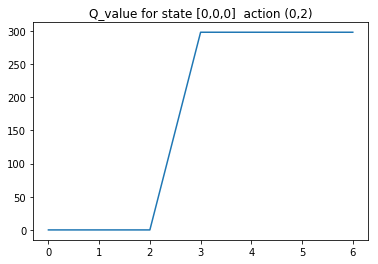

In [187]:
# Q-Value convergence
x = range(0,len(States_track[(0,0,0)][0,2]))
y = States_track[(0,0,0)][0,2]

plt.title('Q_value for state [0,0,0]  action (0,2)')
plt.plot(x,y)
plt.show()

####  Observation: The q-value for the tracked state stablized at value close to 300.

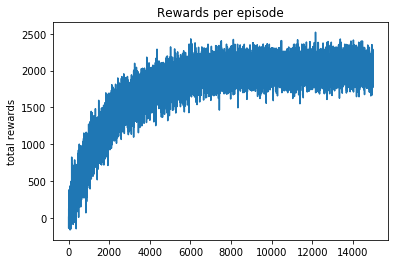

In [183]:
# Check Convergence by tracking total rewards per episode vs episode number
plt.title('Rewards per episode')
plt.plot(list(range(len(rewards_per_episode))), rewards_per_episode)
plt.ylabel("total rewards")
plt.show()

#### Observation: Reward per episode converges around 2000

In [179]:
# Average reward per 100 episode
avg_rewards = []
episodes = len(rewards_per_episode)
index = 0
track_total_reward = 0
for episode_number in range(episodes):
    if index != 100:
        track_total_reward += rewards_per_episode[episode_number]
        index += 1
    else:
        avg_rewards.append(track_total_reward/index)
        track_total_reward = rewards_per_episode[episode_number]
        index = 1

avg_rewards.append(track_total_reward/index)

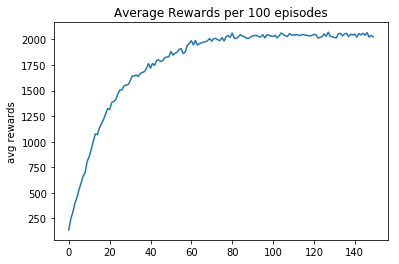

In [185]:
## Check Convergence by tracking average rewards per episode vs episode number
plt.title('Average Rewards per 100 episodes')
plt.plot(list(range(len(avg_rewards))), avg_rewards)
plt.ylabel("avg rewards")
plt.show()

#### Observation: The average reward can be seen increasing and converges at around 2000

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [14]:
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.0009*i))

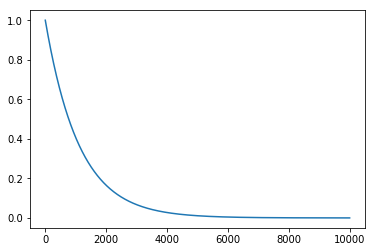

In [7]:
plt.plot(time, epsilon)
plt.show()